In [114]:
# Import packages
import os
import numpy as np
import pandas as pd
from shapely.geometry import Point, LineString, Polygon
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
from matplotlib.ticker import FuncFormatter

%matplotlib inline 
#inline_rc = dict(plt.rcParams)
plt.rcParams.update(plt.rcParams)

#Now set some default parameters. 
plt.rcParams["figure.figsize"] = (15,15) #in inches
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize']=13
plt.rcParams['ytick.labelsize']=13
plt.rcParams['legend.fontsize']=13
plt.rcParams['lines.linewidth']=2

In [3]:
# Remove rows that do not have lat_lon
# Remvove rows that do are doubted to be terorrism attacks
# Remove events that are double counted
# Calculate total number of casualties
# change data format

In [4]:
df = pd.read_csv('gt.csv',header=0,encoding = "Latin")

/Users/nando/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df1 = df.copy()

In [6]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df1[:20])

         eventid  iyear  imonth  iday approxdate  extended resolution  \
0   197000000001   1970       7     2        NaN         0        NaN   
1   197000000002   1970       0     0        NaN         0        NaN   
2   197001000001   1970       1     0        NaN         0        NaN   
3   197001000002   1970       1     0        NaN         0        NaN   
4   197001000003   1970       1     0        NaN         0        NaN   
5   197001010002   1970       1     1        NaN         0        NaN   
6   197001020001   1970       1     2        NaN         0        NaN   
7   197001020002   1970       1     2        NaN         0        NaN   
8   197001020003   1970       1     2        NaN         0        NaN   
9   197001030001   1970       1     3        NaN         0        NaN   
10  197001050001   1970       1     1        NaN         0        NaN   
11  197001060001   1970       1     6        NaN         0        NaN   
12  197001080001   1970       1     8        NaN   

In [7]:
len(df.country_txt.unique())

205

In [157]:
# Using the refrence key select the columns that are needed
df_subset = df1[["iyear", "imonth","iday","extended", # date info
                "summary", # description of event
                "doubtterr","alternative","alternative_txt", # doubt of terrorism
                "multiple","related", # connection between incidents
                "country","country_txt","region","region_txt","provstate","city", # geography
              "latitude","longitude","specificity",
                "attacktype1","attacktype1_txt","attacktype2_txt", # attack information
                "success", # success of attack
                "weaptype1","weaptype1_txt", # weapon information
                "weapsubtype1","weapsubtype1_txt", 
                "targtype1","targtype1_txt", # target information
               "targsubtype1","targsubtype1_txt","corp1","target1",
                "natlty1","natlty1_txt", # nationality of targets
                "gname","individual","suicide", # perp/terrorist name
                "motive", # motive of perp
                "nkill", "nkillus", "nwound","nwoundus", # casualties
                "propvalue" # value of property damage
               ]]

In [158]:
df_subset.info()
# 181,691 records

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Data columns (total 44 columns):
iyear               181691 non-null int64
imonth              181691 non-null int64
iday                181691 non-null int64
extended            181691 non-null int64
summary             115562 non-null object
doubtterr           181690 non-null float64
alternative         29011 non-null float64
alternative_txt     29011 non-null object
multiple            181690 non-null float64
related             25038 non-null object
country             181691 non-null int64
country_txt         181691 non-null object
region              181691 non-null int64
region_txt          181691 non-null object
provstate           181270 non-null object
city                181257 non-null object
latitude            177135 non-null float64
longitude           177134 non-null float64
specificity         181685 non-null float64
attacktype1         181691 non-null int64
attacktype1_txt     181691 non-nu

In [159]:
# add a counter for attacks = nattacks
# add a field that sums the total casualties = tvictims
# add a field that sums the toal us casualties = tvictimsus


In [160]:
df_subset["nattacks"] = 1

/Users/nando/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [161]:
df_subset["tvictims"] = df_subset.nkill + df_subset.nwound

/Users/nando/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [162]:
df_subset["tvictimsus"] = df_subset.nkillus + df_subset.nwoundus

/Users/nando/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [163]:
# Cannot easily create a date column because there are 0 entered for month and day wich are not recognized
# need to remove these entries first

df_clean_months = df_subset[(df_subset["imonth"] > 0)]
df_clean_md = df_subset[(df_subset["iday"] > 0)]
# looks like there are 891 incidents that do not have month or day we can get rid of
# len(df_clean_md)
# 180,800 records


In [164]:
# create a deep copy of all the entries with real attainable dates
df_dates = df_clean_md.copy()

In [165]:
# Creaet date column
df_dates["date"] = pd.to_datetime(df_dates.iyear*10000+df_dates.imonth*100+df_dates.iday,format='%Y%m%d')

In [166]:
# begin by removing incidents that are doubted to be acts of terrorism
# doubtterr is boolean
# 1 = doubt
# 0 = no dobut

df_true = df_dates[df_dates["doubtterr"] == 0]
# len(df_true)
# 138,262 records after removing acts with doubted forms of terrorism

In [167]:
# There are incdients where the recoreded number casualties
# are double counted because they are comprised by multipe attacks/events
# See how many attacks are considered multiple and related events

df_related = df_true.copy()

In [168]:
# Lets look into 9/11 attacks
# At first it seems like the new york events are double counted but the nkills are split between both plane attacks
# Further research shows it was difficult to find an official number of casualties
# The event distorts most statsitscal analysis due to its anominaly

sep11 = df_related[(df_related["multiple"] == 1) & (df_related["iyear"] == 2001) & (df_related["imonth"]==9) & (df_related["iday"]==11)]


In [169]:
# sep11.to_csv("sep11.csv")

In [170]:
# Next step needs to create a dataframe that only has spatial data
# There are Three spatial levels, city(point), country(polygon), region(polygon)
# To create the city level we need to convert the lat, lons into points
# Index number of values need to match up

In [171]:
df_spatial = df_true[df_true["specificity"] < 5]
# len(df_spatial)
# 135,438 records with spatial records

In [172]:
# df_spatial = df_spatial.reset_index(drop=True)

In [173]:
# Create a spatial join between the terrorism data and the country polygon data
# create function to convert lat, lon into Point geometry
def re_geo(df):
    geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
    crs = {'init' :'epsg:4326'}
    gdf = GeoDataFrame(df, crs=crs, geometry=geometry)
    return gdf

In [174]:
df_gtd_points = re_geo(df_spatial)
#len(df_gtd_points)
# 135,438 records. This will be our primary dataset and our total number of records value

In [175]:
# import the shape files for each country
df_cntry_shp = gpd.read_file('Countries_WGS84.shp')

In [176]:
# import the shape files for each country
df_regions = gpd.read_file('regions/Regions.shp')
df_regions.keys()

Index(['OBJECTID', 't', 'region_nam', 'Total_Atta', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')

In [177]:
# Join regions with country shapes
df_gtd_regions = gpd.sjoin(df_regions,df_cntry_shp, how="inner",op = "intersects")
df_gtd_regions.keys()

Index(['OBJECTID_left', 't', 'region_nam', 'Total_Atta', 'Shape_Leng',
       'Shape_Area', 'geometry', 'index_right', 'OBJECTID_right',
       'CNTRY_NAME'],
      dtype='object')

In [294]:
# Import GDP 
gdp = pd.read_csv("gdp.csv",header=0)
gdp = gdp[["Country Name","Total"]]

In [295]:
gdp.head()

,Country Name,Total
0,Afghanistan,2.638650e+11
1,Albania,2.242640e+11
2,Algeria,3.823060e+12
3,Andorra,7.528772e+10
4,Angola,1.583780e+12


In [299]:
# Top 10 Countries by GDP
t10_gdp = gdp.sort_values("Total",ascending=False).head(10)

In [315]:
# Lowest 10 Countries by GDP
b10_gdp = gdp.sort_values("Total",ascending=False).tail(30)

In [180]:
# create a funciton to get all the unique names of the data frames
def series_to_list(dataframe,col):
    x = dataframe[str(col)].unique()
    x = x.tolist()
    return x

In [181]:
# convert pd sereis to list
# show number of elements
gtd_countries = series_to_list(df_gtd_points,'country_txt')
print("Number of countries in GTD: ",len(gtd_countries))
wgs_countries = series_to_list(df_cntry_shp,'CNTRY_NAME')
print("Number of countries in WGS: ",len(wgs_countries))

Number of countries in GTD:  201
Number of countries in WGS:  251


In [182]:
# Python program to illustrate the intersection 
# of two lists using set() and intersection() 
# must set the LARGER list
def Intersection(lst1, lst2): 
    return list(set(lst1).intersection(lst2))

In [183]:
# Python code t get difference of two lists 
# Using set() 
def Diff(li1, li2): 
    x = (list(set(li1) - set(li2)))
    y = (list(set(li2) - set(li1)))
    z = [x,y]
    print("Excluded Countries: ",sorted(x),sorted(y))
    print("Number of countries: ", len(x) + len(y))
    return z

In [184]:
# The following commands will serve as a refrences for country names depending on which source is being called
# Intersection shows the countries that both soruces use the same name

In [185]:
# Intersection between GTD set and WGS set
gtd_wgs_inter = Intersection(wgs_countries,gtd_countries )

In [186]:
# Difference shows the diffrences in names between two soruces

In [187]:
# Difference between GTD and intersection of GTD and WGS 
gtd_wgs_diff_inter = Diff(gtd_countries, gtd_wgs_inter)

Excluded Countries:  ['Bahamas', 'Belarus', 'Bosnia-Herzegovina', 'Czechoslovakia', 'Democratic Republic of the Congo', 'East Germany (GDR)', 'East Timor', 'Falkland Islands', 'Gambia', 'Hong Kong', 'International', 'Kosovo', 'Myanmar', 'New Hebrides', 'North Yemen', "People's Republic of the Congo", 'Republic of the Congo', 'Rhodesia', 'Serbia-Montenegro', 'Slovak Republic', 'South Sudan', 'South Vietnam', 'South Yemen', 'Soviet Union', 'Tanzania', 'Vatican City', 'West Bank and Gaza Strip', 'West Germany (FRG)', 'Yugoslavia'] []
Number of countries:  29


In [188]:
# Show the differnce betwen WGS and GTD
# WGS has more geometries and names than GTD due to more islands in the WGS
gtd_wgs_diff = Diff(wgs_countries,gtd_countries)

Excluded Countries:  ['American Samoa', 'Andorra', 'Anguilla', 'Antarctica', 'Antigua and Barbuda', 'Aruba', 'Bahamas, The', 'Baker Island', 'Bermuda', 'Bosnia and Herzegovina', 'Bouvet Island', 'British Indian Ocean Territory', 'British Virgin Islands', 'Byelarus', 'Cape Verde', 'Cayman Islands', 'Christmas Island', 'Cocos (Keeling) Islands', 'Congo', 'Cook Islands', 'Falkland Islands (Islas Malvinas)', 'Faroe Islands', 'Federated States of Micronesia', 'French Southern & Antarctic Lands', 'Gambia, The', 'Gaza Strip', 'Gibraltar', 'Glorioso Islands', 'Greenland', 'Guam', 'Guernsey', 'Heard Island & McDonald Islands', 'Howland Island', 'Jan Mayen', 'Jarvis Island', 'Jersey', 'Johnston Atoll', 'Juan De Nova Island', 'Kiribati', 'Liechtenstein', 'Man, Isle of', 'Marshall Islands', 'Mayotte', 'Midway Islands', 'Monaco', 'Mongolia', 'Montserrat', 'Myanmar (Burma)', 'Nauru', 'Netherlands Antilles', 'Niue', 'Norfolk Island', 'North Korea', 'Northern Mariana Islands', 'Oman', 'Pacific Islands

In [189]:
# There is no geometry for East Timor?
# Plot the incident points and see where they lay geogr
timor = df_gtd_points[df_gtd_points["country_txt"] == "East Timor"]
timor_base = df_cntry_shp[df_cntry_shp["CNTRY_NAME"] == "Indonesia"]

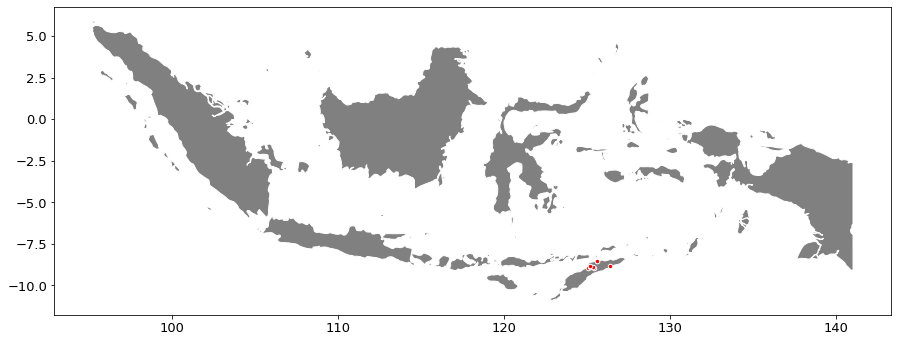

In [190]:
# Shows that the geometry of Indoensia has higher hiearchy than East Timor
# East Timor does not have its own shp file
base = timor_base.plot(color='grey', edgecolor='white')
timor.plot(ax=base, marker='o', color='red',edgecolor='white', markersize=20);

In [191]:
# There is too much variability between the country name of the shape file vs the country name of the GTD
# However eventhough the names of the shape file and those of the GTD do not match analysis can still be done
# This allows to show temporal change
# Attacks that are refrenced to have occured in the Soviet Union,
# will show their location relative to present boundries

In [192]:
# Thats it for data imports, cleaning, and understanding sources
# Now its time for the actual analysis of the data

In [193]:
# Create a variety of functions that will help with quick analysis of maps, gdp, country names, dates, etc

In [194]:
# These functions will help with overall analyis
# Allows for a quick time series graph of two variables
# Show the differnt rankings of each variable

# create a function that takes in five features to quickly give a summary report
# features mus be quantitative or else theyll be lost in grouping
# q6 is the feature you want to group by
def subset_order(dataframe,group,sort):
    subset = dataframe
    print(subset.keys())
    print(subset.describe())
    subset_group = subset.groupby(group).sum()
    subset_group = subset_group.sort_values(sort,ascending = False)
    return subset_group


def two_var_TimeSeries_area(dataframe,time,q1,q2,title,xlab,ylab):
    subset = dataframe[[time,q1,q2]]
    table = subset.groupby(time).sum()
    print("Tables sorted for: ", q1)
    print(table.sort_values(q1,ascending = False).head(5))
    print(table.sort_values(q1,ascending = False).tail(1))
    print("Tables sorted for: ", q2)
    print(table.sort_values(q2,ascending = False).head(5))
    print(table.sort_values(q2,ascending = False).tail(1))
    ax = table.plot(kind="area",stacked=False,alpha=0.3)
    plt.legend(loc='best', fontsize=13)
    plt.title(title)
    ax.set_xlabel(xlab, fontsize=13)
    ax.set_ylabel(ylab, fontsize=13)
    
def two_var_TimeSeries_line(dataframe,time,q1,q2,title,xlab,ylab):
    subset = dataframe[[time,q1,q2]]
    table = subset.groupby(time).sum()
    print("Tables sorted for: ", q1)
    print(table.sort_values(q1,ascending = False).head(5))
    print(table.sort_values(q1,ascending = False).tail(1))
    print("Tables sorted for: ", q2)
    print(table.sort_values(q2,ascending = False).head(5))
    print(table.sort_values(q2,ascending = False).tail(1))
    ax = table.plot(kind="line",stacked=False,alpha=0.3)
    plt.legend(loc='best', fontsize=13)
    plt.title(title)
    ax.set_xlabel(xlab, fontsize=13)
    ax.set_ylabel(ylab, fontsize=13)

In [195]:
# create a function for quickly making a basemap and chosing which points
# filter only point data
# chose the two geometry data frames
# choose the features for base map and points
# choose the value for each feature
# Print the number of records for the map
def country_mapper(df_base,df_points,base_layer,map_points):
    base_data= df_base[df_base["CNTRY_NAME"] == base_layer]
    point_data = df_points[df_points["country_txt"] == map_points]
    print("Number of Attacks: ", len(point_data))
    base = base_data.plot(color='grey', edgecolor='white')
    point_data.plot(ax=base, marker='o', color='red',edgecolor='white')

In [265]:
# These functions will provide an overview anlaysis by deacde

# Function subsets records by decade start and end year
# Creates a new column of % of total attacks
# Sorts records by most number of attacks
# Select top number of records to print
# Renmae columns
# Print top results
# Print Summary Stats
def dec_cat(world,start,end,top):
    dec = world[(world["iyear"] > start-1) & (world["iyear"] < end+1)]
    dec = dec.groupby("country_txt").sum()
    dec["attack%"] = (dec.nattacks/dec.nattacks.sum())*100
    dec = dec.sort_values("nattacks",ascending=False)
    dec = dec.rename(columns={"gname":"Terrorist_Group","iyear":"Year","imonth":"Month",
                              "tvictims":"Victims","country_txt":"Country"})
    print(dec.head(top))
    return dec

# Function subsets records by decade start and end year
# Filters the records by minimum number of victims
# Sorts records by most number of attacks
# Select top number of records to print
# Rename Columns
# Print Summary Stats
def dec_leth(world,start,end,filt,top):
    dec = world[(world["iyear"] > start-1) & (world["iyear"] < end+1)]
    dec = dec[(dec["tvictims"] >= filt)]
    dec = dec.rename(columns={"gname":"Terrorist_Group","iyear":"Year","imonth":"Month",
                              "tvictims":"Victims","country_txt":"Country"})
    print(dec.head(top))
    print(dec.describe())
    return dec

# Function subsets records by decade start and end year
# Creates a new column of % of total attacks
# Sorts records by most number of attacks of most deadly terrorist group(gname)
# Select top number of records to print
# Rename Columns
# Print Summary Stats
def dec_gname(world,start,end,top):
    dec = world[(world["iyear"] > start-1) & (world["iyear"] < end+1)]
    dec = dec.groupby("gname").sum()
    dec["attack%"] = (dec.nattacks/dec.nattacks.sum())*100
    dec = dec.sort_values("nattacks",ascending=False)
    print(dec.head(top))
    return dec


# Function subsets records by decade start and end year
# Creates a new column of % of total attacks
# Sorts records by most number of victims of most deadly terrorist group(gname)
# Select top number of records to print
# Rename Columns
# Print Summary Stats
def dec_gname_leth(world,start,end,top):
    dec = world[(world["iyear"] > start-1) & (world["iyear"] < end+1)]
    dec = dec.groupby("gname").sum()
    dec["attack%"] = (dec.nattacks/dec.nattacks.sum())*100
    dec = dec.sort_values("tvictims",ascending=False)
    dec = dec.rename(columns={"gname":"Terrorist_Group","iyear":"Year","imonth":"Month",
                              "tvictims":"Victims","country_txt":"Country"})
    print(dec.head(top))
    print(dec.describe())
    return dec

Tables sorted for:  tvictims
       tvictims  nattacks
iyear                    
2015    59755.0     12133
2014    56961.0     13449
2016    55710.0     11142
2013    49264.0      9947
2017    37011.0      8590
       tvictims  nattacks
iyear                    
1971       83.0       314
Tables sorted for:  nattacks
       tvictims  nattacks
iyear                    
2014    56961.0     13449
2015    59755.0     12133
2016    55710.0     11142
2013    49264.0      9947
2017    37011.0      8590
       tvictims  nattacks
iyear                    
1973      600.0       298


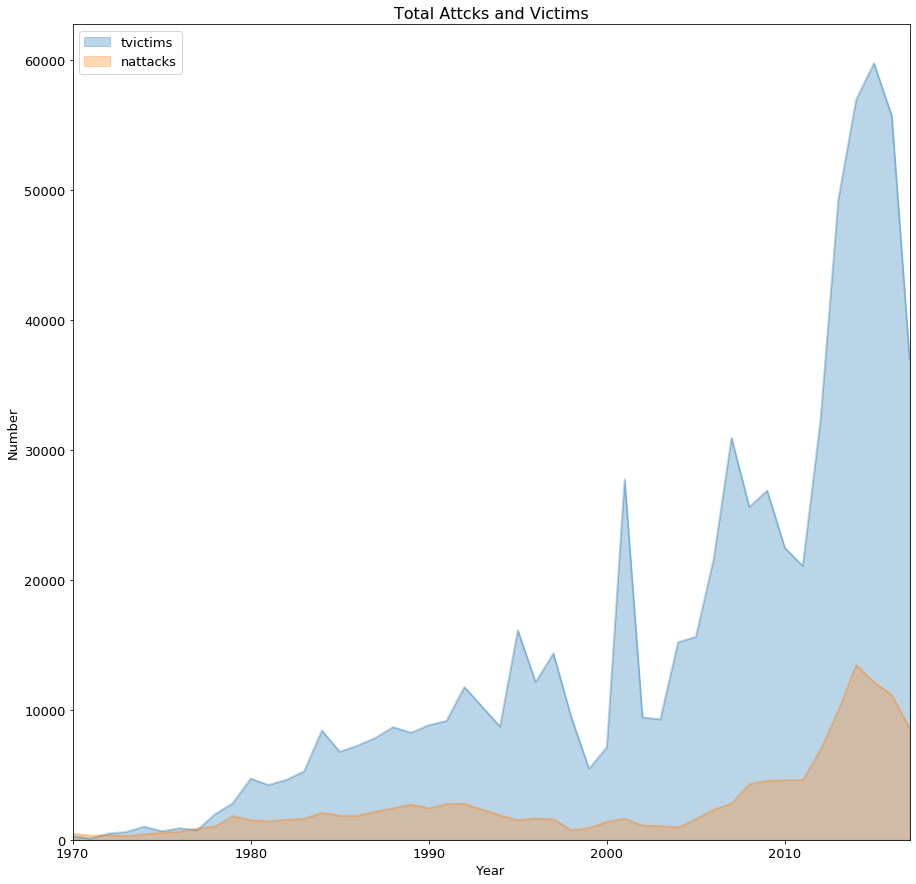

In [197]:
# We see that for the majority of the past 50 years the frequency of terrorist attacks stayed the same
# There was a sharp spike in attacks in 2014
# Attacks and victims are on the decline since 2014

two_var_TimeSeries_area(df_gtd_points,"iyear","tvictims","nattacks","Total Attcks and Victims","Year","Number")

Tables sorted for:  nkill
         nkill   nwound
iyear                  
2014   33416.0  34726.0
2015   29413.0  37452.0
2016   25763.0  33952.0
2017   18783.0  20341.0
2013   18073.0  32905.0
       nkill  nwound
iyear               
1971   111.0    59.0
Tables sorted for:  nwound
         nkill   nwound
iyear                  
2015   29413.0  37452.0
2014   33416.0  34726.0
2016   25763.0  33952.0
2013   18073.0  32905.0
2012   11262.0  21775.0
       nkill  nwound
iyear               
1971   111.0    59.0


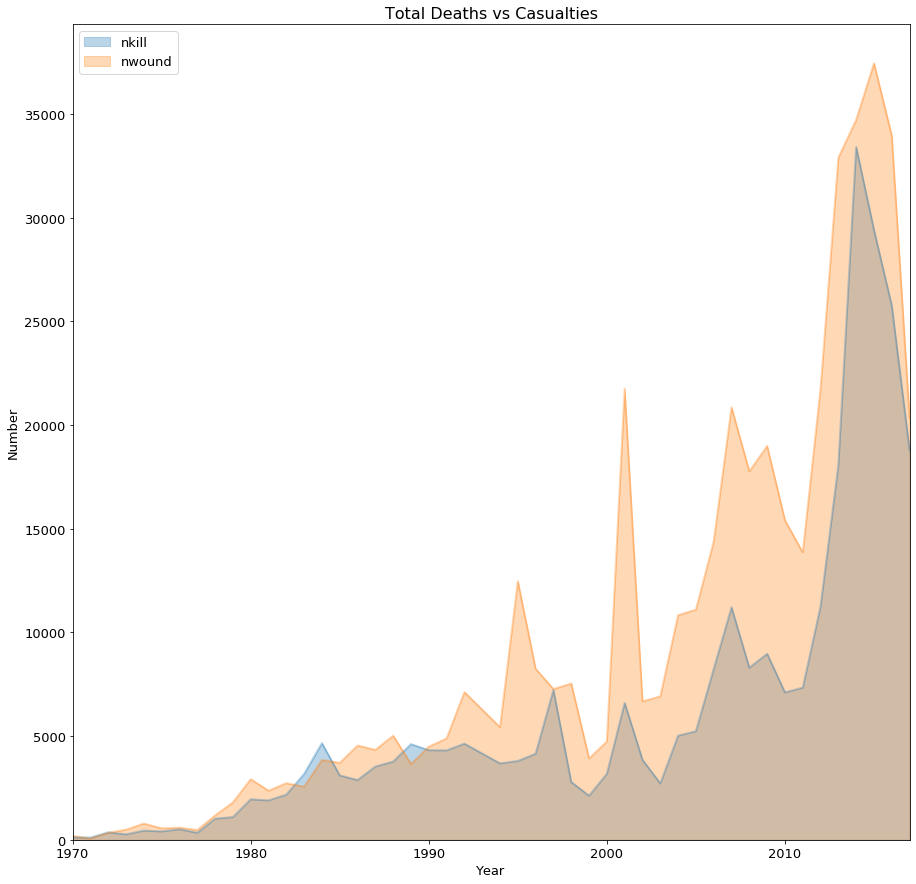

In [198]:
two_var_TimeSeries_area(df_gtd_points,"iyear","nkill","nwound","Total Deaths vs Casualties","Year","Number")

Tables sorted for:  tvictims
            tvictims  nattacks
date                          
2001-09-11   19502.0         8
1995-03-20    5535.0         5
1998-08-07    4337.0         4
2007-08-14    2031.0         6
2004-03-11    1991.0         7
            tvictims  nattacks
date                          
1970-01-01       0.0         1
Tables sorted for:  nattacks
            tvictims  nattacks
date                          
2016-09-21      67.0       126
2016-12-01      49.0        99
2013-10-09      90.0        81
2014-06-14     226.0        78
2016-08-08     287.0        76
            tvictims  nattacks
date                          
1970-01-01       0.0         1


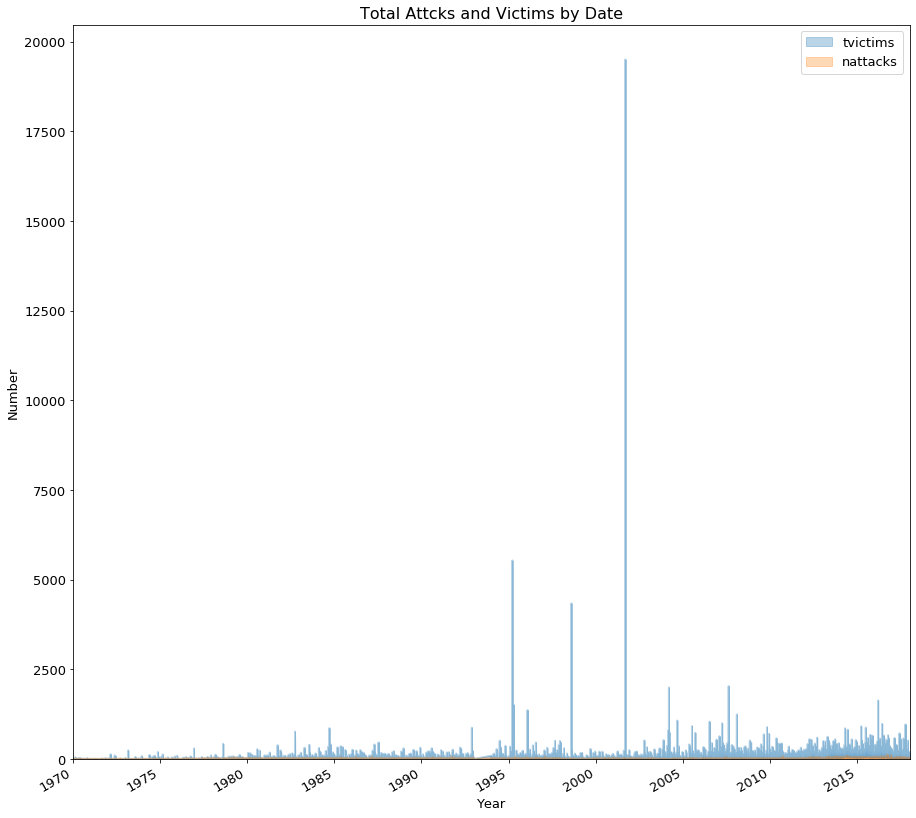

In [199]:
# Septembr 11 remains the most deadly attack in history by a factor of 4
two_var_TimeSeries_area(df_gtd_points,"date","tvictims","nattacks","Total Attcks and Victims by Date","Year","Number")

Tables sorted for:  nkill
             nkill   nwound
date                       
2001-09-11  3009.0  16494.0
2014-08-03  1056.0     54.0
2014-06-10   737.0     90.0
2014-07-17   679.0     56.0
2017-10-14   610.0    340.0
            nkill  nwound
date                     
1970-01-01    0.0     0.0
Tables sorted for:  nwound
             nkill   nwound
date                       
2001-09-11  3009.0  16494.0
1995-03-20    17.0   5518.0
1998-08-07   238.0   4099.0
2004-03-11   195.0   1800.0
2016-03-09    53.0   1582.0
            nkill  nwound
date                     
1970-01-01    0.0     0.0


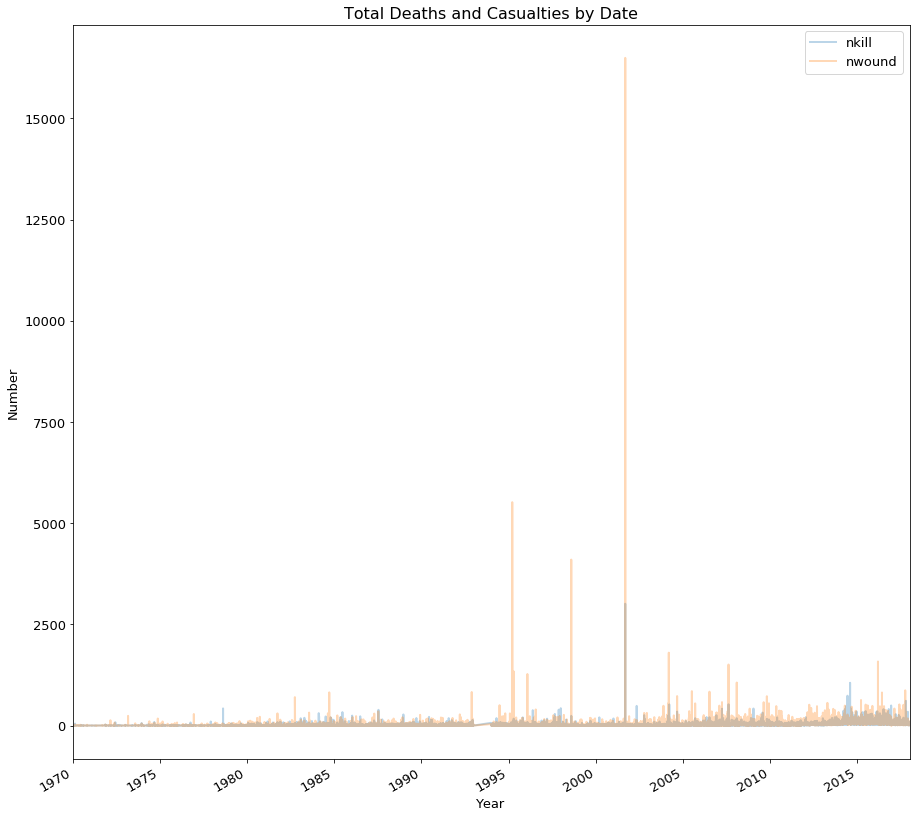

In [200]:
two_var_TimeSeries_line(df_gtd_points,"date","nkill","nwound","Total Deaths and Casualties by Date","Year","Number")

Tables sorted for:  nkillus
       nkillus  nwoundus
iyear                   
2001    2915.0      47.0
1988     195.0      13.0
1995     182.0     744.0
1998      74.0       2.0
2016      74.0     137.0
       nkillus  nwoundus
iyear                   
1997       1.0      47.0
Tables sorted for:  nwoundus
       nkillus  nwoundus
iyear                   
1984       8.0     797.0
1995     182.0     744.0
2016      74.0     137.0
1970      21.0     117.0
1986      11.0      99.0
       nkillus  nwoundus
iyear                   
1999       7.0       1.0


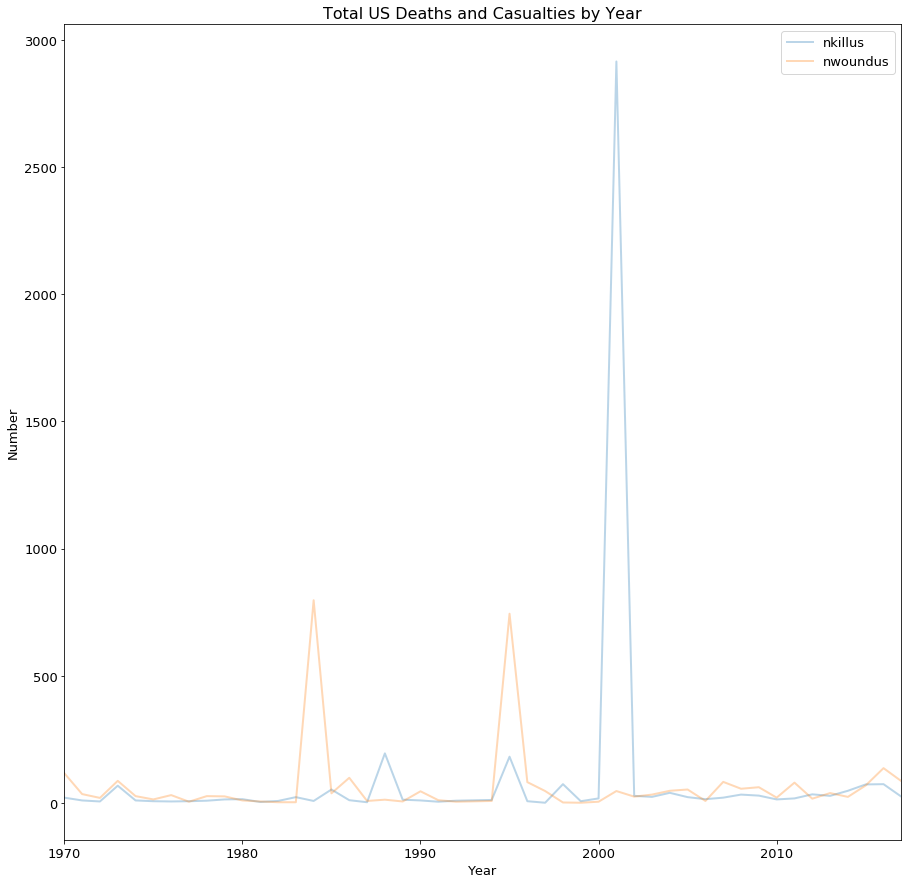

In [201]:
two_var_TimeSeries_line(df_gtd_points,"iyear","nkillus","nwoundus","Total US Deaths and Casualties by Year","Year","Number")

In [202]:
# Generally terroist attacks will wound victims rather than kill
casualties = df_gtd_points[['nkill','nwound','nattacks',"tvictims","nkillus","nwoundus"]]
casualties_sub = subset_order(casualties,'nkill','nattacks')
casualties_sub["attack%"] = (casualties_sub.nattacks/casualties_sub.nattacks.sum())*100
print(casualties_sub.head(10))
casualties_sub.tail(10)

Index(['nkill', 'nwound', 'nattacks', 'tvictims', 'nkillus', 'nwoundus'], dtype='object')
               nkill         nwound  nattacks       tvictims       nkillus  \
count  129080.000000  124966.000000  135438.0  124614.000000  96916.000000   
mean        2.231670       3.585631       1.0       5.580826      0.043935   
std        10.873857      41.114418       0.0      47.735334      6.195264   
min         0.000000       0.000000       1.0       0.000000      0.000000   
25%         0.000000       0.000000       1.0       0.000000      0.000000   
50%         0.000000       0.000000       1.0       1.000000      0.000000   
75%         2.000000       2.000000       1.0       4.000000      0.000000   
max      1384.000000    8191.000000       1.0    9574.000000   1360.000000   

           nwoundus  
count  96731.000000  
mean       0.033195  
std        3.262284  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max      751.000000  
        n

,nwound,nattacks,tvictims,nkillus,nwoundus,attack%
nkill,,,,,,
168.0,650.0,1,818.0,168.0,650.0,0.000775
108.0,76.0,1,184.0,0.0,0.0,0.000775
171.0,0.0,1,171.0,7.0,0.0,0.000775
105.0,245.0,1,350.0,0.0,0.0,0.000775
184.0,0.0,1,0.0,0.0,0.0,0.000775
188.0,817.0,1,1005.0,0.0,0.0,0.000775
102.0,552.0,1,654.0,0.0,0.0,0.000775
98.0,20.0,1,118.0,0.0,0.0,0.000775
122.0,270.0,1,392.0,0.0,0.0,0.000775


Text(0.5, 1.0, 'Top 10 Frequency of Attacks by Number of Deaths')

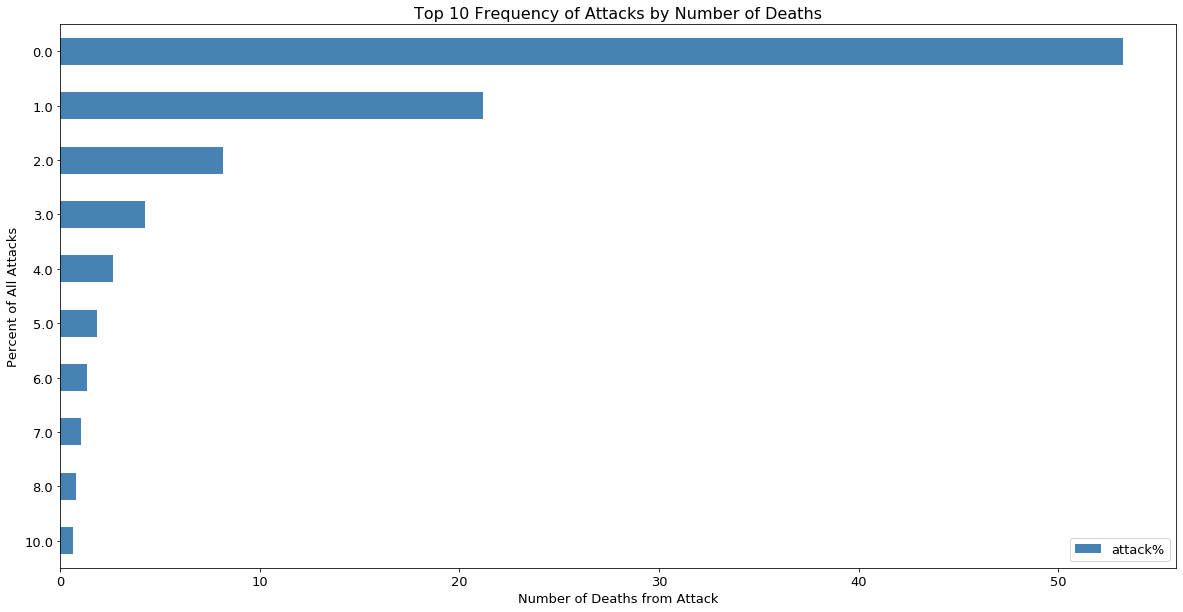

In [203]:
# Over 50% of attacks ar non-fatal attacks
casualties_sub_plot = casualties_sub.head(10)
ax = casualties_sub_plot['attack%'].plot(kind='barh', color = 'steelblue',figsize=(20,10), fontsize=13)
plt.gca().invert_yaxis()
plt.legend(loc='best', fontsize=13)
ax.set_xlabel('Number of Deaths from Attack', fontsize=13)
ax.set_ylabel('Percent of All Attacks', fontsize=13)
ax.set_title('Top 10 Frequency of Attacks by Number of Deaths')

In [204]:
# Lets look in the oppisite direction, how many attacks are completly fatal(0 wounded)
fatal = df_gtd_points[(df_gtd_points['nkill'] > 0) & (df_gtd_points['nwound'] == 0)]
fatal_filt = fatal[["nkill","nattacks","tvictims"]]
fatal_filt.describe()

,nkill,nattacks,tvictims
count,27213.000000,27213.0,27213.000000
mean,3.384375,1.0,3.384375
std,10.848399,0.0,10.848399
min,1.000000,1.0,1.000000
25%,1.000000,1.0,1.000000
50%,1.000000,1.0,1.000000
75%,3.000000,1.0,3.000000
max,670.000000,1.0,670.000000


In [205]:
# Look into the summary of 100% fatal attacks
fatal_sub = subset_order(fatal_filt,"nkill","nattacks")
# Find the relative frequency of these attacks compared to all attacks
fatal_sub["attack%"] = (fatal_sub.nattacks/df_gtd_points.nattacks.sum())*100
print(fatal_sub.head(10))
fatal_sub.tail(10)
fatal_sub

Index(['nkill', 'nattacks', 'tvictims'], dtype='object')
              nkill  nattacks      tvictims
count  27213.000000   27213.0  27213.000000
mean       3.384375       1.0      3.384375
std       10.848399       0.0     10.848399
min        1.000000       1.0      1.000000
25%        1.000000       1.0      1.000000
50%        1.000000       1.0      1.000000
75%        3.000000       1.0      3.000000
max      670.000000       1.0    670.000000
       nattacks  tvictims    attack%
nkill                               
1.0       15502   15502.0  11.445828
2.0        4378    8756.0   3.232475
3.0        2113    6339.0   1.560123
4.0        1239    4956.0   0.914810
5.0         876    4380.0   0.646790
6.0         577    3462.0   0.426025
7.0         402    2814.0   0.296815
8.0         276    2208.0   0.203783
10.0        239    2390.0   0.176465
9.0         189    1701.0   0.139547


,nattacks,tvictims,attack%
nkill,,,
1.0,15502,15502.0,11.445828
2.0,4378,8756.0,3.232475
3.0,2113,6339.0,1.560123
4.0,1239,4956.0,0.914810
5.0,876,4380.0,0.646790
...,...,...,...
111.0,1,111.0,0.000738
114.0,1,114.0,0.000738
115.0,1,115.0,0.000738


In [206]:
# Over 27k of the 135,000 attacks attacks have a 100% fatality rate ~ 20%
print("100% fatality % = ", (len(fatal)/len(df_gtd_points)) *100)

100% fatality % =  20.0925884906747


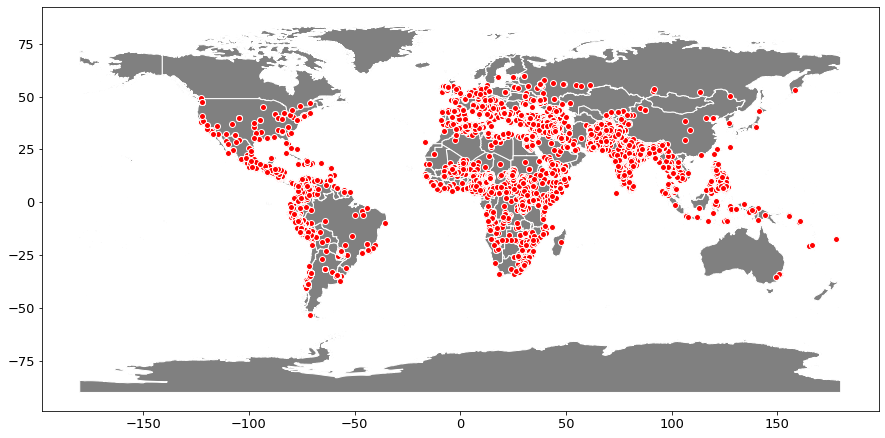

In [207]:
# Lets map where these attacks are occuring
fatal_base = df_cntry_shp.plot(color='grey',edgecolor='white')
fatal_loc = fatal.plot(ax=fatal_base,marker='o',color='red',edgecolor='white')

             nattacks
country_txt          
Iraq             3732
Number of Attacks:  3732


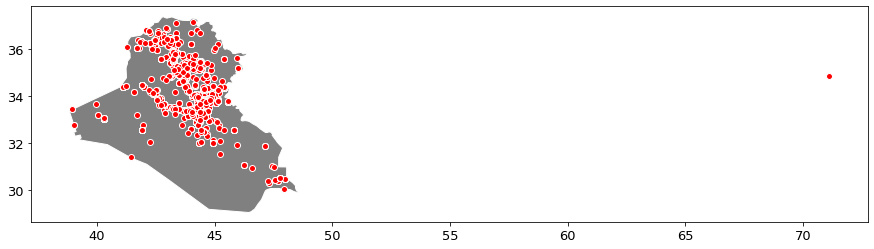

In [208]:
# There seems to be no obvious geographical generalization of where these attacks occur
# Lets Observe the country with the most 100% fatal attack
fatal_country = fatal[["country_txt","nattacks"]]
tc = fatal_country.groupby("country_txt").sum().sort_values("nattacks",ascending=False).head(1)
print(tc)
country_mapper(df_cntry_shp,fatal,"Iraq","Iraq")

In [209]:
# There is an obvious cluster in these attacks
# They stretch from Baghdad up through Fallujah, Mosul, etc. and into the Syrian Border
iraq_ft = fatal[fatal["country_txt"]=="Iraq"]
iraq_ft.groupby("city").sum().sort_values("nattacks",ascending=False).head(5)

,iyear,imonth,iday,extended,doubtterr,alternative,multiple,country,region,latitude,...,individual,suicide,nkill,nkillus,nwound,nwoundus,propvalue,nattacks,tvictims,tvictimsus
city,,,,,,,,,,,,,,,,,,,,,
Baghdad,1808157,5835,14059,27,0.0,0.0,27.0,85405,8990,29939.981194,...,0,28,1656.0,12.0,0.0,0.0,-29007.0,899,1656.0,12.0
Mosul,1199579,3934,9671,16,0.0,0.0,53.0,56620,5960,21666.653906,...,0,51,3609.0,0.0,0.0,0.0,-6336.0,596,3609.0,0.0
Baqubah,307660,961,2433,5,0.0,0.0,3.0,14535,1530,5162.706724,...,0,8,291.0,0.0,0.0,5.0,-2277.0,153,291.0,5.0
Kirkuk,275441,810,2062,3,0.0,0.0,3.0,13015,1370,4856.677507,...,0,9,208.0,0.0,0.0,0.0,-1980.0,137,208.0,0.0
Fallujah,175016,586,1357,2,0.0,0.0,9.0,8265,870,2900.557012,...,0,8,531.0,4.0,0.0,0.0,-1089.0,87,531.0,4.0


In [210]:
# Spatial context can help in understanding the reasons for the attack, millitary conflict,
# boundry dispute, politcal dispute, etc.
# However the the spatial componenet does not always give a clear picture why the attack was so fatal
# Lets look into the attack method used instead

#fatal.keys()
fatal_filt2 = fatal[["attacktype1_txt","weaptype1_txt","nkill","nattacks"]]
fatal_sub2 = subset_order(fatal_filt2,"attacktype1_txt","nattacks")
# Find the relative frequency of these attacks compared to this subgroup of attacks
fatal_sub2["attack%"] = (fatal_sub2.nattacks/fatal_sub2.nattacks.sum())*100
fatal_sub2["death%"] = (fatal_sub2.nkill/fatal_sub2.nkill.sum())*100
fatal_sub2

Index(['attacktype1_txt', 'weaptype1_txt', 'nkill', 'nattacks'], dtype='object')
              nkill  nattacks
count  27213.000000   27213.0
mean       3.384375       1.0
std       10.848399       0.0
min        1.000000       1.0
25%        1.000000       1.0
50%        1.000000       1.0
75%        3.000000       1.0
max      670.000000       1.0


,nkill,nattacks,attack%,death%
attacktype1_txt,,,,
Armed Assault,41511.0,10497,38.573476,45.072151
Assassination,11773.0,7948,29.206629,12.782984
Bombing/Explosion,18741.0,5120,18.814537,20.348755
Hostage Taking (Kidnapping),8551.0,1998,7.342079,9.284574
Unknown,8906.0,1296,4.762430,9.670029
Facility/Infrastructure Attack,1296.0,184,0.676147,1.407181
Hostage Taking (Barricade Incident),671.0,67,0.246206,0.728564
Unarmed Assault,368.0,59,0.216808,0.399570
Hijacking,282.0,44,0.161687,0.306192


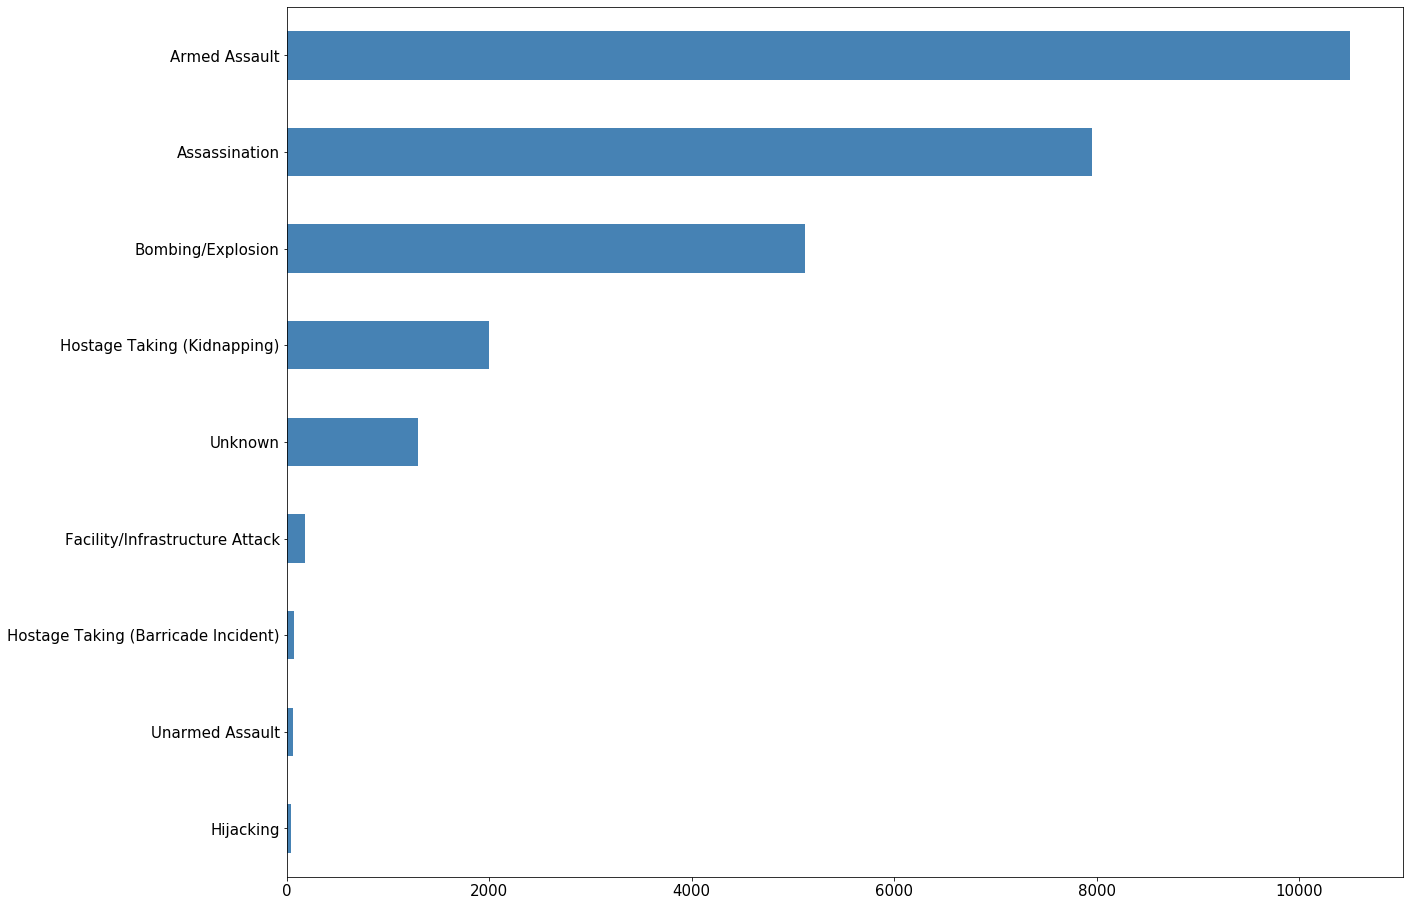

In [211]:
# Lets look at the number of kills distribution by each attack type
ax = fatal_filt2['attacktype1_txt'].value_counts().plot(kind='barh',color="steelblue",figsize=(20,16), fontsize=15)
plt.gca().invert_yaxis()

Text(0.5, 1.0, 'Frequency of Attacks by Attack Type')

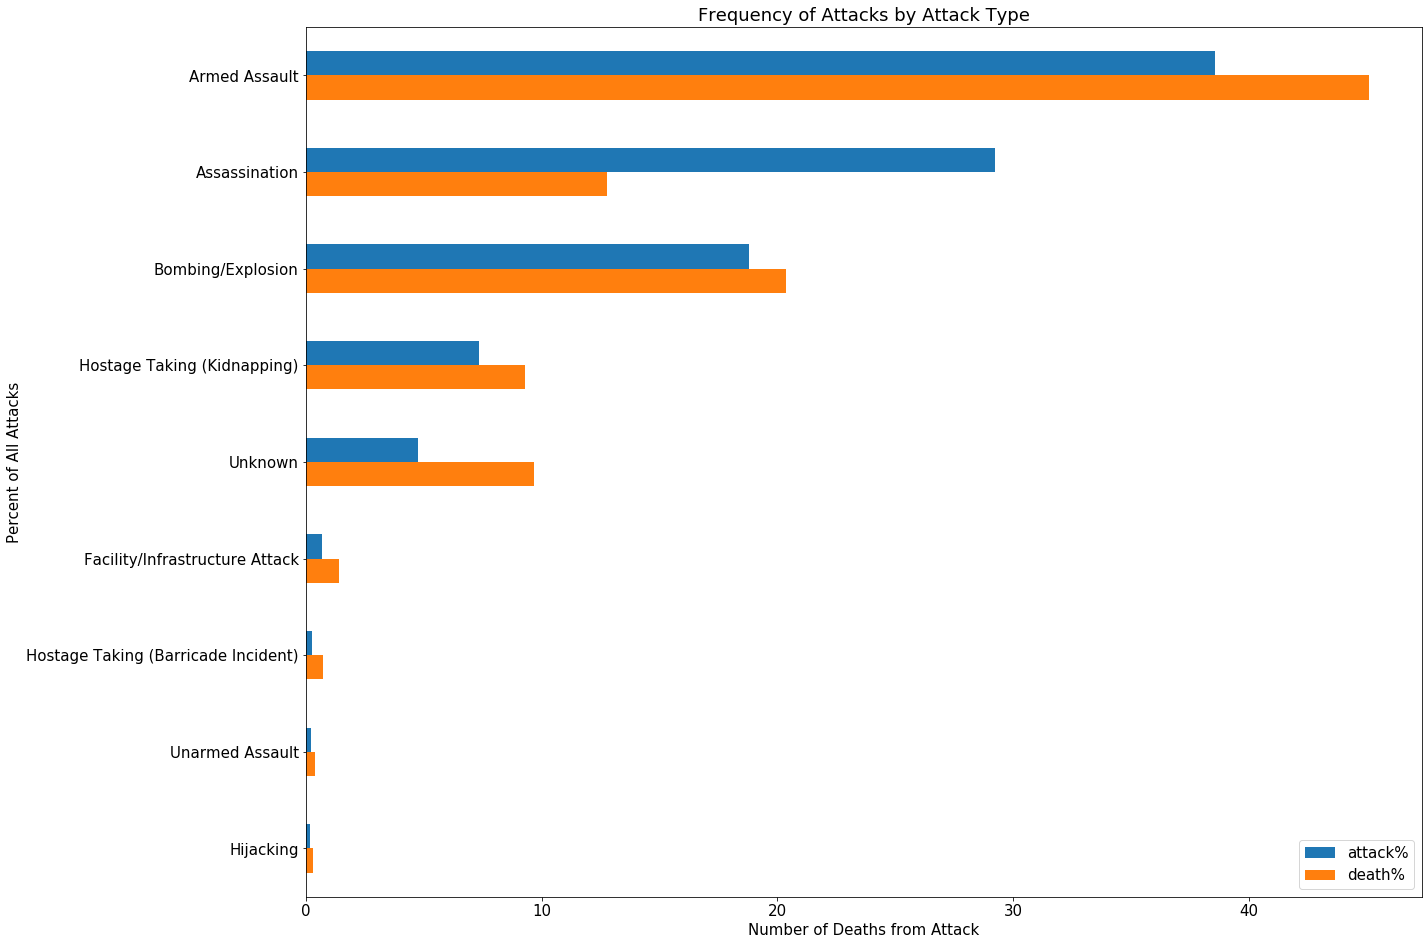

In [212]:
# Most 100% Fatal attacks are committed by Armed Assult, Assassination, and Bombings
# However the most deadly to attack frequency ratio would be Armed-Assult
# Eventhough Assassination is a popular optin, it is not as effective as other means
# This may be a result to the nature of assassination have small targets

ax = fatal_sub2[['attack%','death%']].plot(kind='barh',figsize=(20,16), fontsize=15)
plt.legend(loc='lower right', fontsize=15)
plt.gca().invert_yaxis()
ax.set_xlabel('Number of Deaths from Attack', fontsize=15)
ax.set_ylabel('Percent of All Attacks', fontsize=15)
ax.set_title('Frequency of Attacks by Attack Type',fontsize=18)

In [213]:
# Lets look at the number of kills distribution by each attack type
fatal_assult = fatal_filt2[fatal_filt2["attacktype1_txt"] == "Armed Assault"]
fatal_as = fatal_filt2[fatal_filt2["attacktype1_txt"] == "Assassination"]
fatal_hi = fatal_filt2[fatal_filt2["attacktype1_txt"] == "Hijacking"]

In [214]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #print(fatal_assult['nkill'].value_counts())

Text(0.5, 1.0, 'Kill Distribution from Armed Assault Attacks')

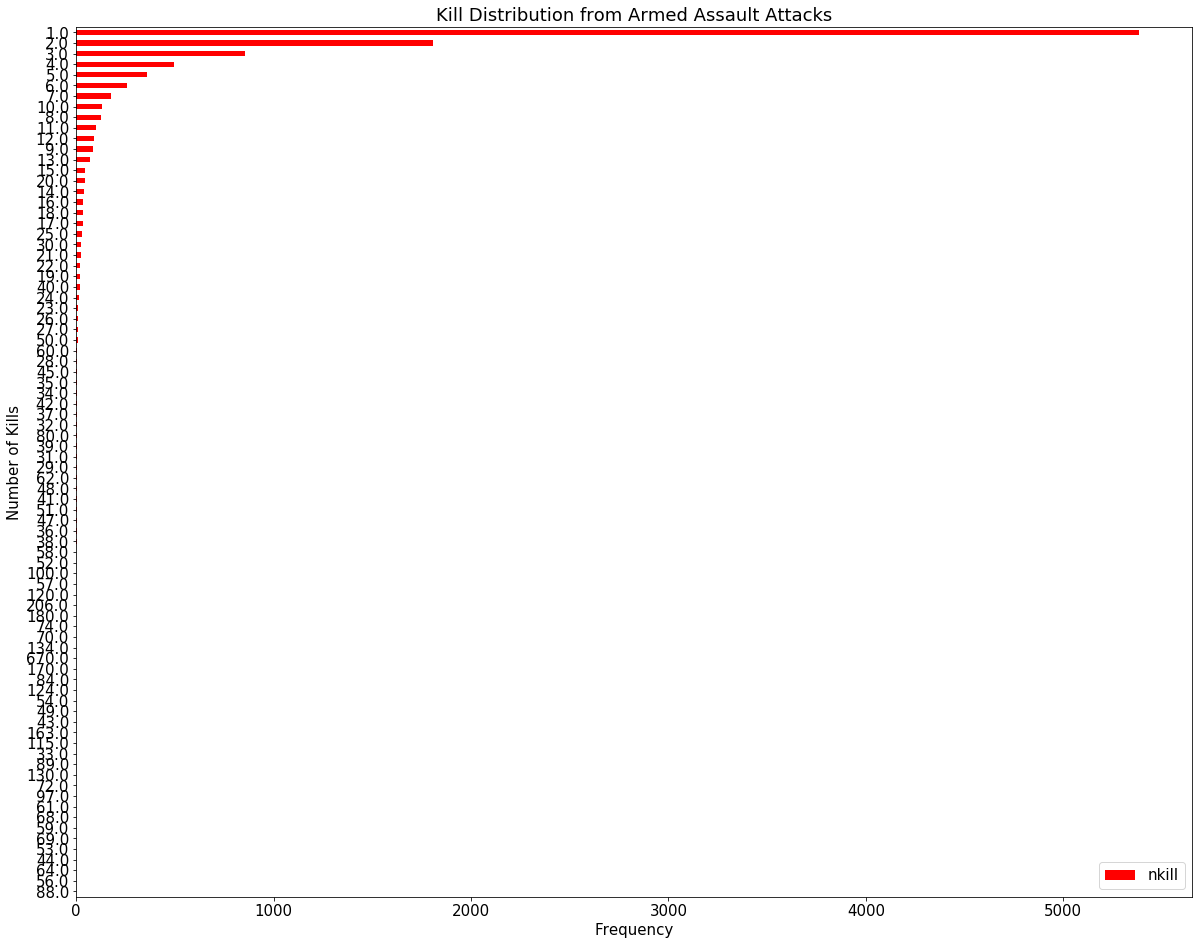

In [215]:
# As seen in the graph below, Armed Assults do have a large emphasis on single target kills
# However the range of these attacks is broad, ranging kills from 1-670 kills
ax = fatal_assult['nkill'].value_counts().plot(kind='barh',color='red',figsize=(20,16), fontsize=15)
plt.legend(loc='lower right', fontsize=15)
plt.gca().invert_yaxis()
ax.set_xlabel('Frequency', fontsize=15)
ax.set_ylabel('Number of Kills', fontsize=15)
ax.set_title("Kill Distribution from Armed Assault Attacks",fontsize=18)

Text(0.5, 1.0, 'Kill Distribution from Assassinations')

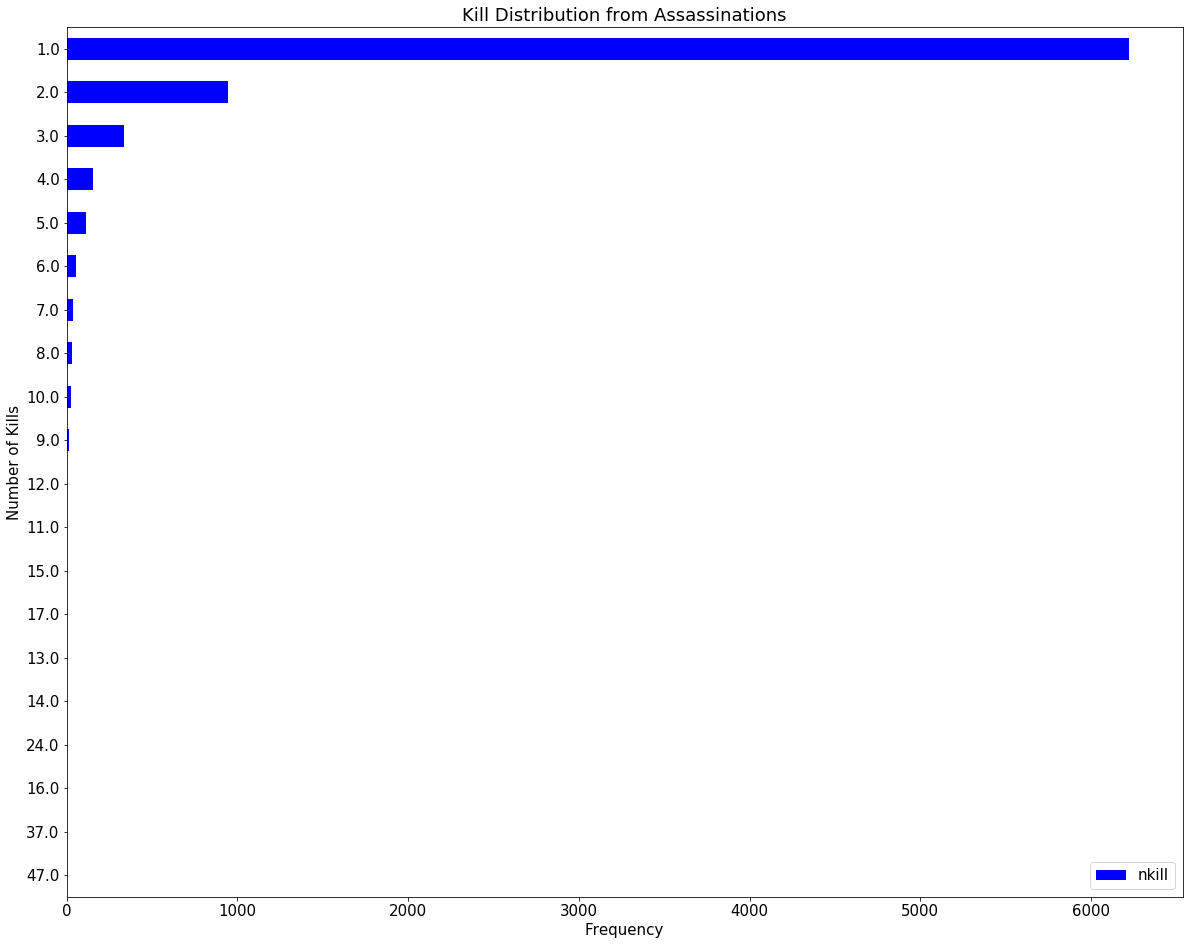

In [216]:
# As seen in the graph below, Assasination Attacks have a similar distribution to Armed Assaults
# Hoever, assassinations do have a larger emphasis on single target kills
# Additionally, the range of these attacks is more compact, ranging in attacks from 1-47
ax = fatal_as['nkill'].value_counts().plot(kind='barh',color='blue',figsize=(20,16), fontsize=15)
plt.legend(loc='lower right', fontsize=15)
plt.gca().invert_yaxis()
ax.set_xlabel('Frequency', fontsize=15)
ax.set_ylabel('Number of Kills', fontsize=15)
ax.set_title("Kill Distribution from Assassinations",fontsize=18)

In [217]:
print(fatal_hi['nkill'].value_counts())

1.0      20
2.0       8
3.0       6
4.0       2
12.0      1
17.0      1
46.0      1
6.0       1
5.0       1
20.0      1
14.0      1
100.0     1
Name: nkill, dtype: int64


Text(0.5, 1.0, 'Kill Distribution from Hijackings')

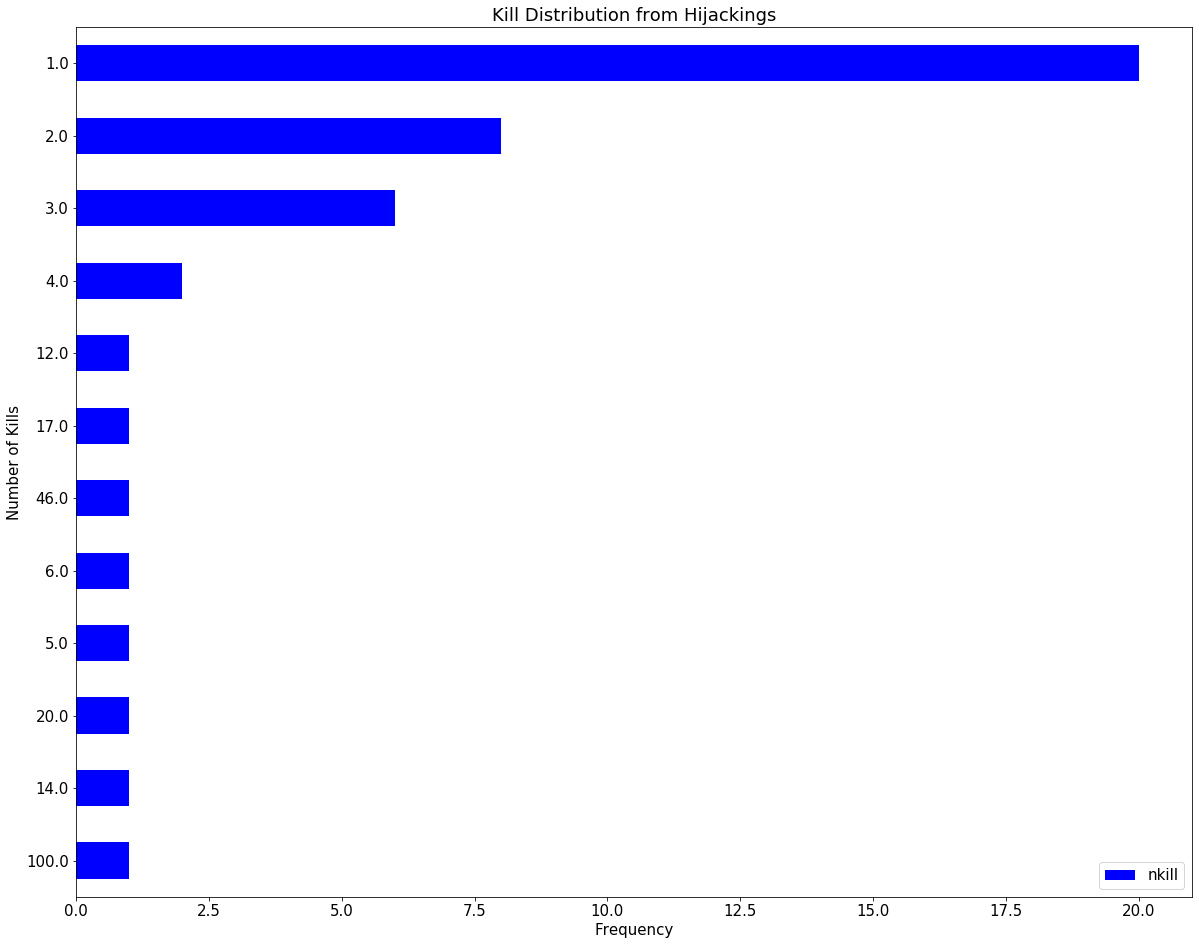

In [218]:
# As seen in the graph below, Hijacking Attacks have a similar concentration around 1 kill
# Hoever, hijackins do have a larger larger range in kills than assassination attacks
# Additionally,hijackings occur much less frequently than all other forms of attacks and do not have a high kill threshold
ax = fatal_hi['nkill'].value_counts().plot(kind='barh',color='blue',figsize=(20,16), fontsize=15)
plt.legend(loc='lower right', fontsize=15)
plt.gca().invert_yaxis()
ax.set_xlabel('Frequency', fontsize=15)
ax.set_ylabel('Number of Kills', fontsize=15)
ax.set_title("Kill Distribution from Hijackings",fontsize=18)

In [219]:
# Going back to Iraq
# Going back to Iraq
fatal_iq = fatal[fatal["country_txt"]=="Iraq"]
fatal_iq["attacktype1_txt"].value_counts()

Bombing/Explosion                      1479
Armed Assault                          1305
Assassination                           454
Hostage Taking (Kidnapping)             258
Unknown                                 223
Hostage Taking (Barricade Incident)       8
Facility/Infrastructure Attack            3
Unarmed Assault                           2
Name: attacktype1_txt, dtype: int64

Text(0.5, 1, 'Top 3 Attack Types with 100% Victim Fatality in Iraq')

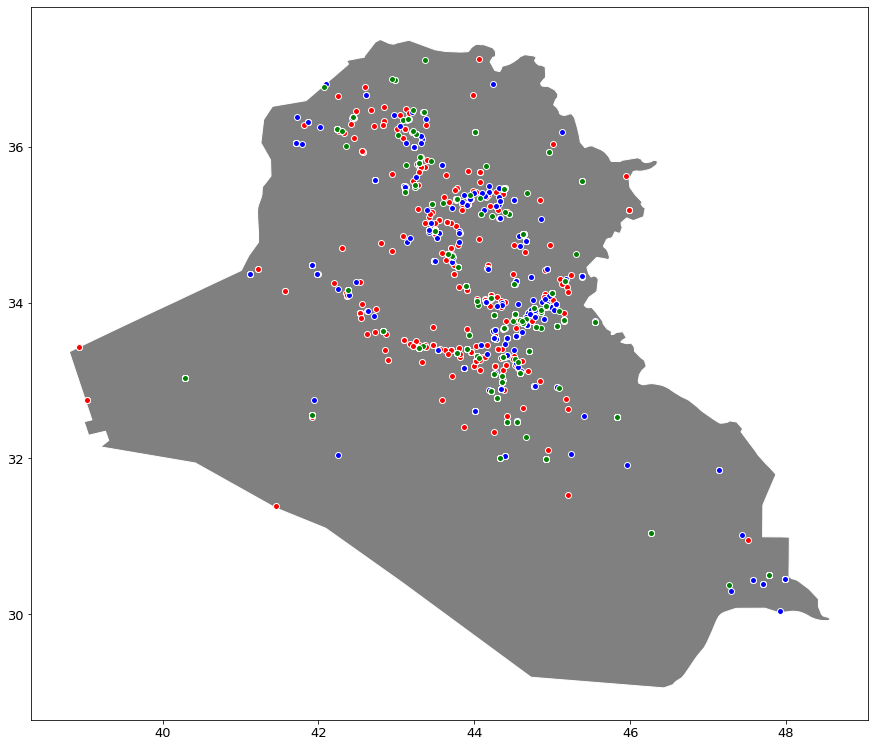

In [220]:
# Can now see the different types of attacks used for the 100% Fatal attacks of Iraq
iq_bomb = fatal[(fatal["country_txt"]=="Iraq") & (fatal["attacktype1_txt"] == "Bombing/Explosion")]
iq_aa = fatal[(fatal["country_txt"]=="Iraq") & (fatal["attacktype1_txt"] == "Armed Assault")]
iq_as = fatal[(fatal["country_txt"]=="Iraq") & (fatal["attacktype1_txt"] == "Assassination")]
iq_base = df_cntry_shp[df_cntry_shp["CNTRY_NAME"] == "Iraq"].plot(color='grey',edgecolor='white')
iq_bomb = iq_bomb.plot(ax=iq_base,marker='o',color='red',edgecolor='white')
iq_aa = iq_aa.plot(ax=iq_base,marker='o',color='blue',edgecolor='white')
iq_as = iq_as.plot(ax=iq_base,marker='o',color='green',edgecolor='white')
ax.set_title("Top 3 Attack Types with 100% Victim Fatality in Iraq",fontsize=18)

In [221]:
# The previous analysis only focused on attacks that had 100% victim fatality. What about Terrorism in general?
# Global Stats
df_gtd_points["attacktype1_txt"].value_counts()

Bombing/Explosion                      72678
Armed Assault                          26645
Assassination                          14092
Hostage Taking (Kidnapping)             8468
Facility/Infrastructure Attack          7728
Unknown                                 3906
Hostage Taking (Barricade Incident)      796
Unarmed Assault                          709
Hijacking                                416
Name: attacktype1_txt, dtype: int64

Text(0.5, 1.0, 'Global Attack Type Distribution')

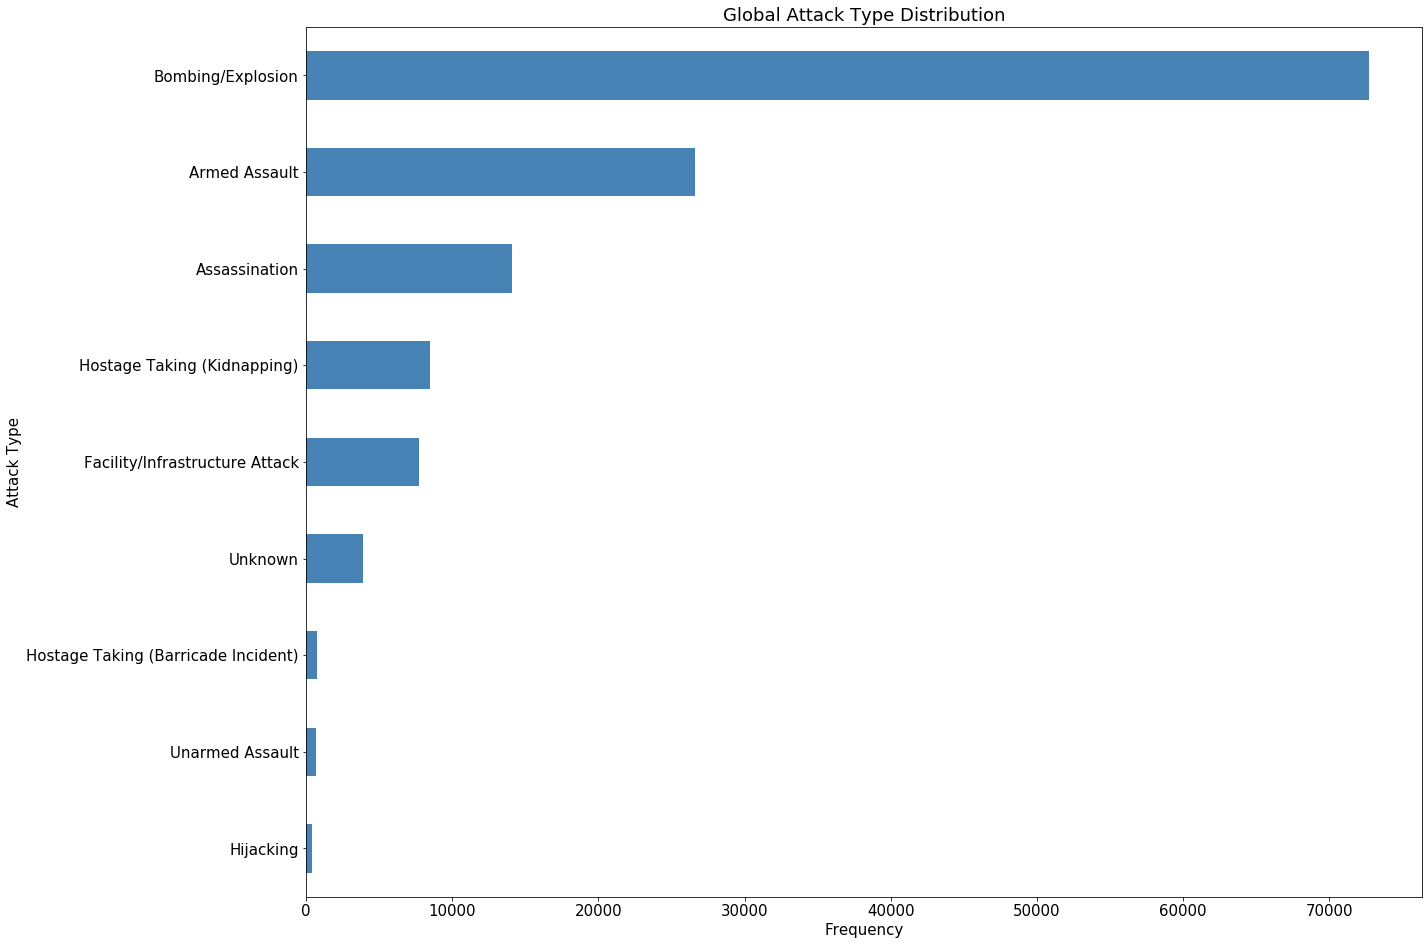

In [222]:
# Lets look at the number of kills distribution by each attack type
ax = df_gtd_points["attacktype1_txt"].value_counts().plot(kind='barh',color="steelblue",figsize=(20,16), fontsize=15)
plt.gca().invert_yaxis()
ax.set_xlabel('Frequency', fontsize=15)
ax.set_ylabel('Attack Type', fontsize=15)
ax.set_title("Global Attack Type Distribution",fontsize=18)

Text(0.5, 1.0, 'Global Bombing Attacks')

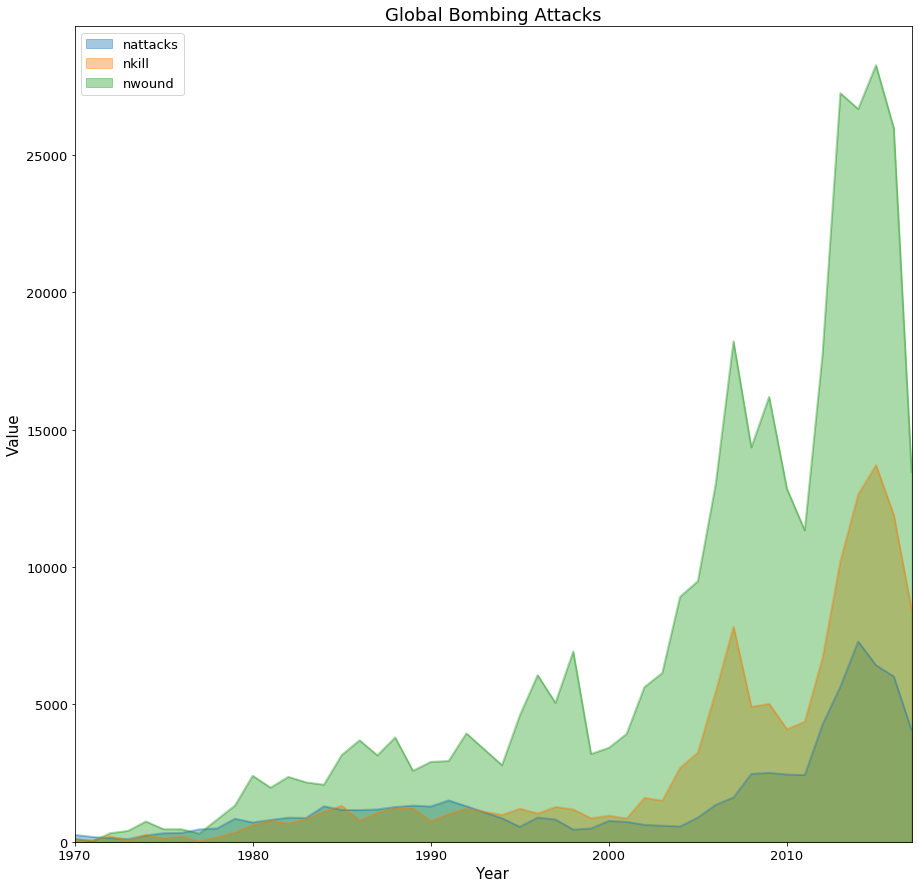

In [223]:
# Historical Trend of Attacks Using Bombs
# The trend in bomb casualties tends to increase as time and usage increaes until 2014
# There is a sharp decline in bomb attacks and as a result a delcine in casualties

atype_time = df_gtd_points[["attacktype1_txt","iyear","nattacks","nkill","nwound"]]
abomb_time = atype_time[atype_time["attacktype1_txt"] == "Bombing/Explosion"]
abomb_time = abomb_time.groupby("iyear").sum()
ax = abomb_time.plot(kind="area",stacked=False,alpha=0.4)
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Value', fontsize=15)
ax.set_title("Global Bombing Attacks",fontsize=18)

Text(0.5, 1.0, 'Global Assassination Attacks')

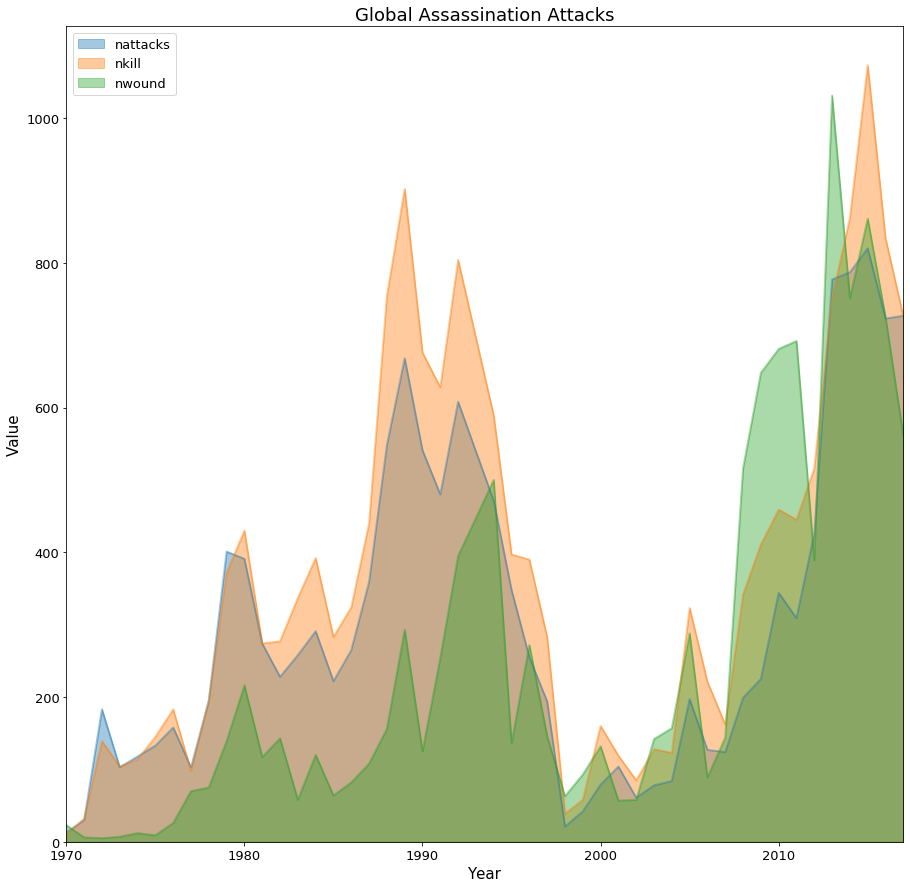

In [224]:
# Historical Trend of Attacks Using Assassinations
# The use of assasinatations is volotile as there are frequent rises and decreases in usuage
# There was an alltime low right before 1999
# Usuage climbed back up to an all time-high by 2014

a_time = atype_time[atype_time["attacktype1_txt"] == "Assassination"]
a_time = a_time.groupby("iyear").sum()
ax = a_time.plot(kind="area",stacked=False,alpha=0.4)
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Value', fontsize=15)
ax.set_title("Global Assassination Attacks",fontsize=18)

Text(0.5, 1.0, 'Global Armed Assault Type Distribution')

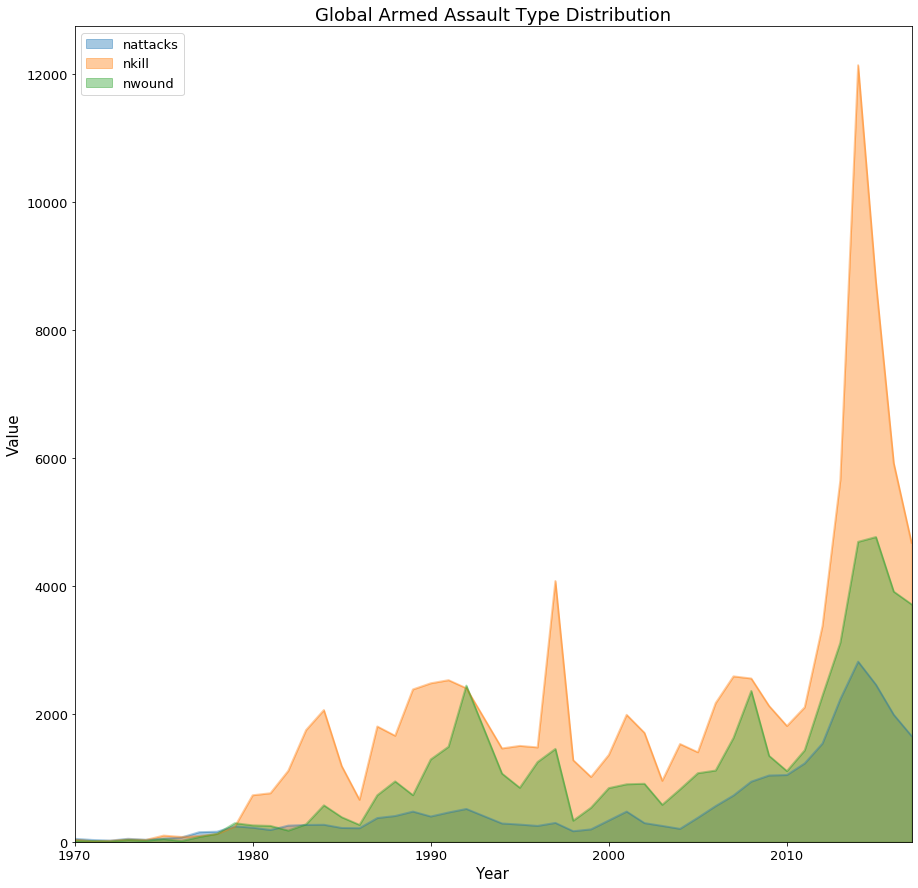

In [225]:
# Historical Trend of Attacks Using Armed Assaults
# The use of armed assaults demonstrates a graduale incrase in number of attacks
# There were sudden peaks in kills and attacks in the late 1990s and around 2014

aa_time = atype_time[atype_time["attacktype1_txt"] == "Armed Assault"]
aa_time = aa_time.groupby("iyear").sum()
ax = aa_time.plot(kind="area",stacked=False,alpha=0.4)
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Value', fontsize=15)
ax.set_title("Global Armed Assault Type Distribution",fontsize=18)

Text(0.5, 1.0, 'Global Hijacking Attacks')

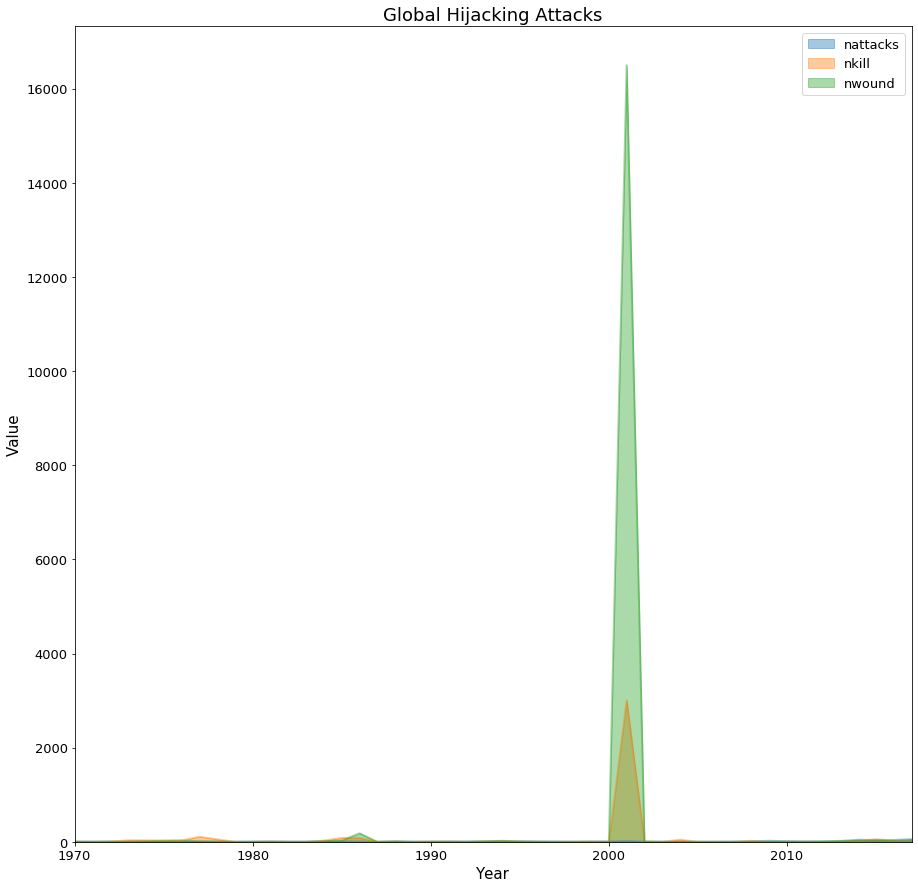

In [226]:
# Historical Trend of Attacks by Hijackings
# The trend in hijacking is not inutaive but somewhat easy to explain
# There is a very obvious spike in casualties right after 2000
# This of course is due to the 9/11 attcks in New York City
# This attack is very much an outlier to the rest of hijacking disributinon it distorts the data

ahi_time = atype_time[atype_time["attacktype1_txt"] == "Hijacking"]
ahi_time = ahi_time.groupby("iyear").sum()
ax = ahi_time.plot(kind="area",stacked=False,alpha=0.4)
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Value', fontsize=15)
ax.set_title("Global Hijacking Attacks",fontsize=18)

In [227]:
# Taking a closer look at hijacking attack distribution
# The standard devation for kills and wounded is insanely large
ahi_time.describe()

,nattacks,nkill,nwound
count,44.000000,44.000000,44.000000
mean,9.454545,82.477273,385.227273
std,11.913359,451.516797,2485.583885
min,1.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000
50%,5.000000,4.500000,1.500000
75%,9.000000,21.250000,11.500000
max,56.000000,3005.000000,16497.000000


Text(0.5, 1.0, 'Global Hijacking Attacks')

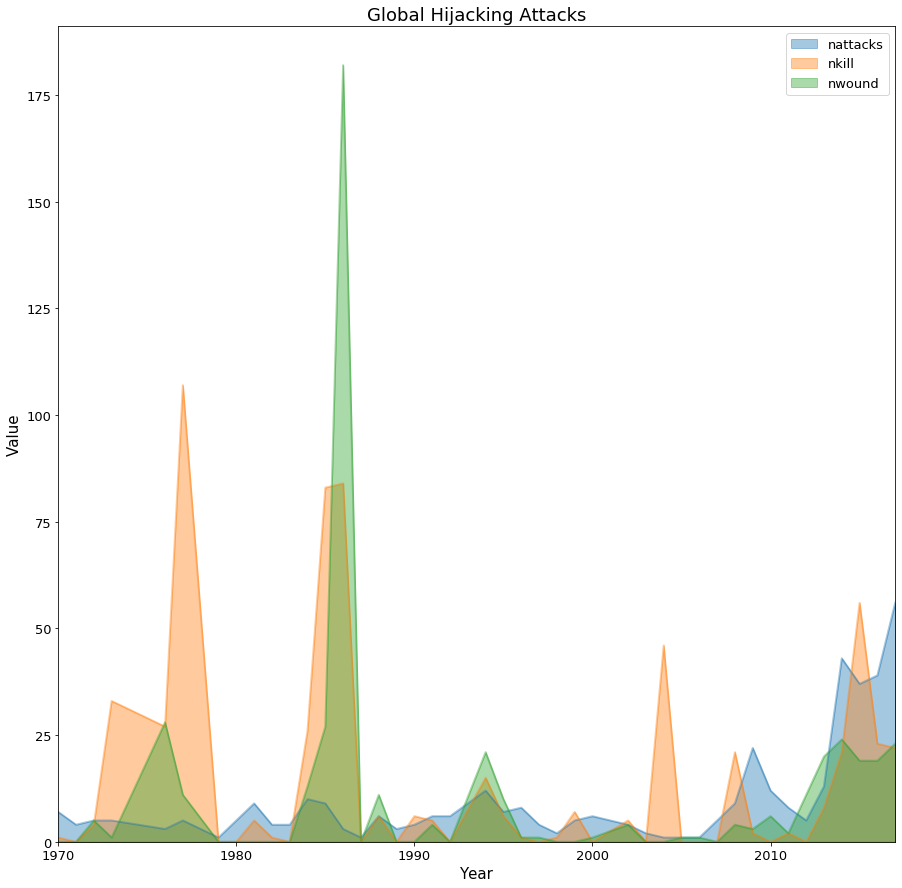

In [228]:
# Remove the attacks of 9/11 on New York
# After removing the attacks on New York the graph is easier to interprate
# It is now easier to see that the frequency of highjackings was low for most of history but is now increasing
# Overall there seems to be low casualites most years with occasional spikesd
ahi_time_filt = ahi_time[ahi_time["nkill"] < 1900]
ax = ahi_time_filt.plot(kind="area",stacked=False,alpha=0.4)
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Value', fontsize=15)
ax.set_title("Global Hijacking Attacks",fontsize=18)

In [261]:
# Now we have an undestanding of how many attacks have occured throughout the time period
# There is also better understanding of the types of attacks that are carried out
# The trends of such attacks
# Now its time to see who and where these attacks have been taking place


#dec_cat(world,start,end,top):

df_gtd_short = df_gtd_points[["iyear","country_txt","nkill","nwound","nattacks","tvictims","suicide","gname"]]

# Show the top 10 countries with the most number of terrorist attacks
alltime = dec_cat(df_gtd_short,1970,2018,10)

                    Year    nkill    nwound  nattacks   Victims  suicide  \
country_txt                                                                
Iraq            43398783  65673.0  125287.0     21565  184323.0     1994   
Pakistan        23490997  18490.0   37384.0     11681   55119.0      451   
Afghanistan     21527450  32260.0   38493.0     10695   68050.0     1079   
India           19564116  14377.0   25781.0      9743   39207.0       38   
Colombia        11346225   8228.0    8237.0      5687   15836.0        2   
Peru             9760249   7649.0    3120.0      4911   10346.0        0   
Philippines      9611757   5088.0    9261.0      4789   14028.0        9   
United Kingdom   7862801   2432.0    5155.0      3950    6303.0        7   
Nigeria          6990880  20581.0    9302.0      3472   19249.0      354   
Thailand         6316565   2053.0    6700.0      3142    8708.0        0   

                  attack%  
country_txt                
Iraq            15.922415  
Pak

Text(0.5, 1.0, 'Top 10 Countries for All Terrorist Attacks')

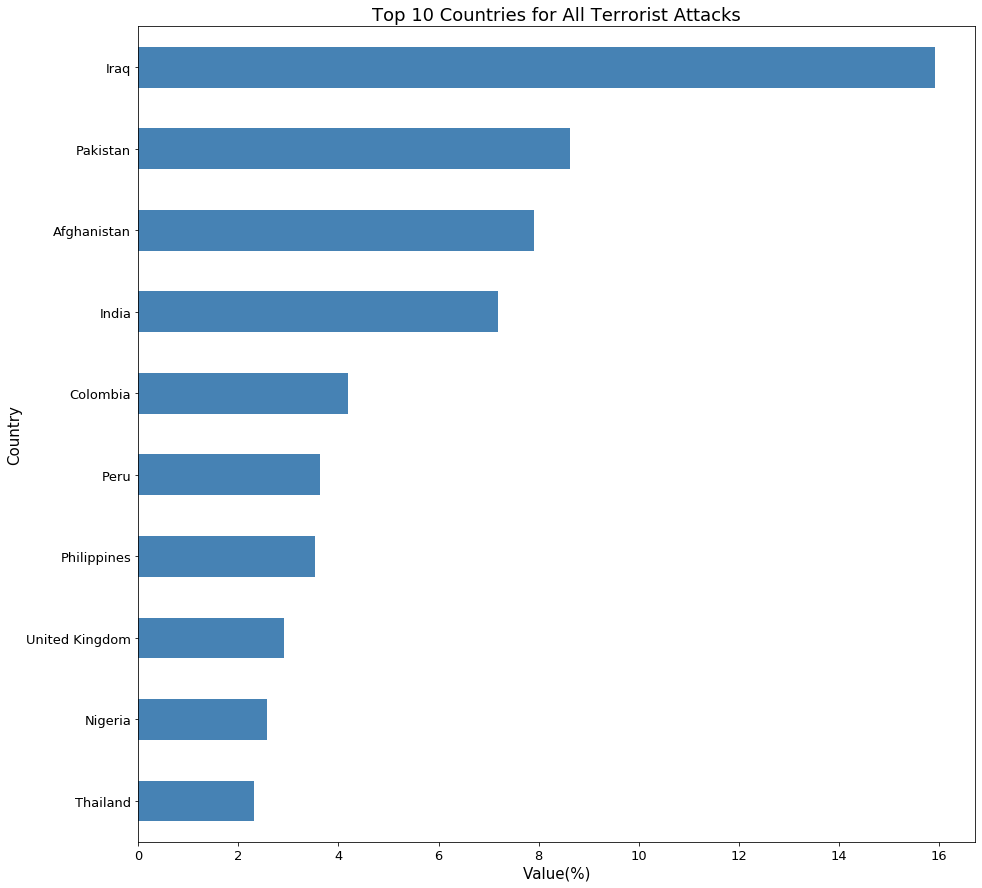

In [247]:
t10 = alltime.head(10)
ax = t10["attack%"].plot(kind='barh',color = 'steelblue')
plt.gca().invert_yaxis()
ax.set_xlabel('Value(%)', fontsize=15)
ax.set_ylabel('Country', fontsize=15)
ax.set_title("Top 10 Countries for All Terrorist Attacks",fontsize=18)

In [252]:
# Were these countries always hosts of terrorism? Lets check a snapshot from the beging of the data set
# Each snapshot caputres the top 10 countries for terroirst attacks each decade
# The Attack % is relative to that decade not total attacks
the70s = dec_cat(df_gtd_short,1970,1980,10)

                   Year   nkill  nwound  nattacks  Victims  suicide    attack%
country_txt                                                                   
United States   2484734   163.0   551.0      1259    711.0        0  15.114046
United Kingdom  2408291  1208.0  1157.0      1219   1317.0        0  14.633854
Spain           1724519   371.0   723.0       872   1072.0        0  10.468187
Italy           1528706   287.0   720.0       773    964.0        0   9.279712
El Salvador     1197453   974.0   178.0       605   1065.0        0   7.262905
France           890013    59.0   217.0       450    243.0        0   5.402161
Colombia         741923   239.0   104.0       375    325.0        0   4.501801
Turkey           567530   156.0   305.0       287    458.0        0   3.445378
Argentina        466031   128.0   106.0       236    223.0        0   2.833133
Israel           350104   241.0   947.0       177   1132.0        0   2.124850


In [253]:
the80s = dec_cat(df_gtd_short,1980,1990,10)

                   Year   nkill  nwound  nattacks  Victims  suicide    attack%
country_txt                                                                   
Peru            7663872  6235.0  1849.0      3859   7680.0        0  17.801458
El Salvador     4266313  3010.0  1098.0      2150   3989.0        0   9.917889
Colombia        4160573  3077.0  2235.0      2095   5252.0        0   9.664176
Chile           2974766   155.0   566.0      1498    718.0        0   6.910232
Spain           2481215   479.0  1180.0      1250   1637.0        0   5.766215
United Kingdom  2010946   861.0  1264.0      1013   1909.0        0   4.672940
India           1653562  2222.0  3420.0       832   5619.0        0   3.837992
Sri Lanka       1653990  4840.0  3202.0       832   8034.0        0   3.837992
South Africa    1537441   469.0  1903.0       774   2366.0        1   3.570440
Philippines     1337273  1235.0  1943.0       673   3145.0        0   3.104530


In [254]:
the90s = dec_cat(df_gtd_short,1990,2000,10)

                   Year   nkill  nwound  nattacks  Victims  suicide    attack%
country_txt                                                                   
Colombia        3581815  3402.0  2873.0      1796   5960.0        0  10.176214
Peru            2778122  2088.0  1292.0      1395   3378.0        0   7.904131
India           2357445  4606.0  7250.0      1182  11594.0        4   6.697263
Turkey          1949435  1401.0  1374.0       978   2762.0       16   5.541390
United Kingdom  1947591   339.0  1521.0       977   1817.0        0   5.535724
Algeria         1870208  5617.0  5469.0       937  10843.0        2   5.309083
France          1372324    34.0   309.0       688    343.0        0   3.898238
Pakistan        1316582  1421.0  3818.0       660   5180.0        2   3.739589
Philippines     1144522  1042.0  2071.0       574   3064.0        3   3.252309
Spain           1069101   148.0   551.0       536    666.0        0   3.036999


In [255]:
y2k = dec_cat(df_gtd_short,2000,2010,10)

                 Year    nkill   nwound  nattacks  Victims  suicide    attack%
country_txt                                                                   
Iraq         11678687  23007.0  53356.0      5817  74832.0      681  22.098545
India         5843768   6112.0  12224.0      2912  17710.0       25  11.062569
Pakistan      5007895   6411.0  13144.0      2494  19142.0      180   9.474604
Afghanistan   4549491   5638.0   7288.0      2266  12388.0      260   8.608441
Thailand      2577814   1034.0   2890.0      1284   3908.0        0   4.877863
Philippines   2213306   1451.0   3257.0      1103   4502.0        7   4.190252
Russia        2096381   2325.0   4607.0      1045   6566.0       48   3.969912
Colombia      2041002   1769.0   2686.0      1018   4157.0        2   3.867340
Algeria       1619777   2533.0   2192.0       808   4546.0       16   3.069559
Sri Lanka     1275555   2019.0   4219.0       636   6028.0       43   2.416138


In [256]:
y210s = dec_cat(df_gtd_short,2010,2018,10)

                 Year    nkill   nwound  nattacks   Victims  suicide  \
country_txt                                                            
Iraq         33872338  44345.0  77794.0     16818  117111.0     1361   
Pakistan     18309331  11852.0  21767.0      9094   33396.0      301   
Afghanistan  17901866  27274.0  32142.0      8888   57251.0      864   
India        11624018   3172.0   4992.0      5772    8046.0       10   
Nigeria       6497746  19584.0   8967.0      3226   18531.0      354   
Philippines   5712584   1782.0   2650.0      2836    4400.0        3   
Somalia       4298431   4960.0   4920.0      2134    9202.0      146   
Yemen         4275974   4436.0   5996.0      2123    9873.0      128   
Thailand      3986616    975.0   3549.0      1980    4517.0        0   
Libya         3465275   1642.0   2026.0      1720    3325.0       63   

               attack%  
country_txt             
Iraq         23.556271  
Pakistan     12.737587  
Afghanistan  12.449051  
India     

Text(0.5, 1.0, 'Trend in Suicide Attacks 1970-2017')

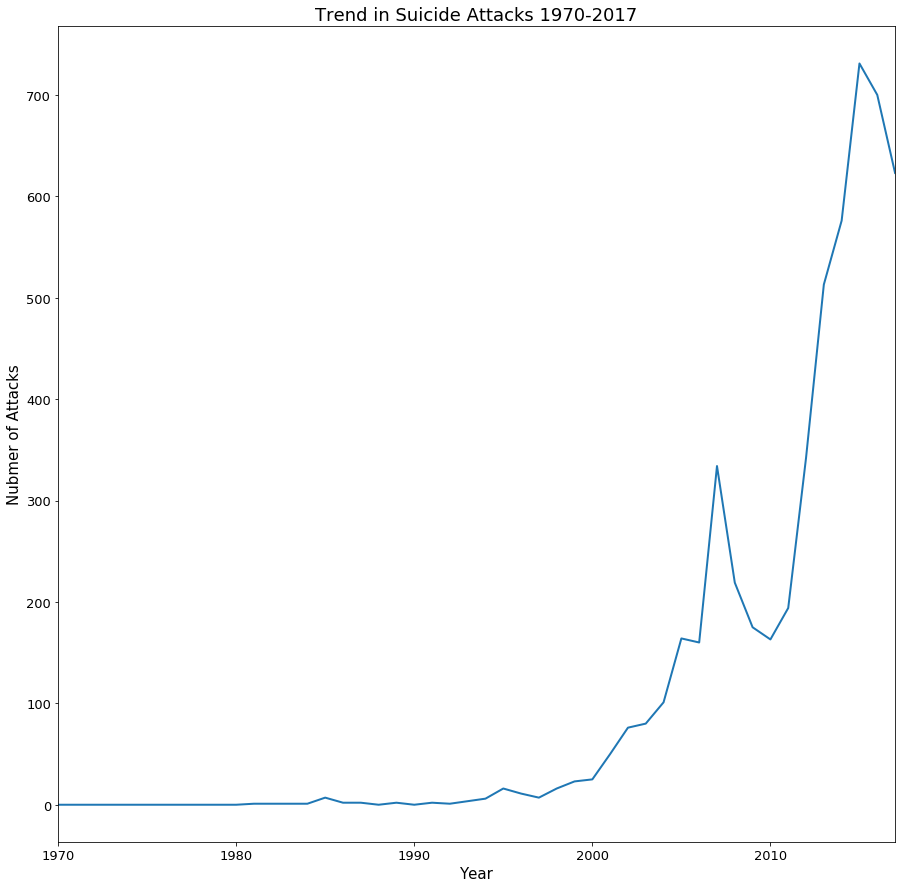

In [259]:
# Other than seeing how the top ten countries changed each year, there was another phenomena that changed with time
# The use of suicide attacks did not become popular until after the year 2000
df_gtd_short = df_gtd_points[["iyear","country_txt","nkill","nwound","nattacks","tvictims","suicide"]]
suicide = df_gtd_short.groupby("iyear").sum()
ax = suicide["suicide"].plot(kind='line')
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Nubmer of Attacks', fontsize=15)
ax.set_title("Trend in Suicide Attacks 1970-2017",fontsize=18)

In [269]:
# Beyond where these attacks are happening, is who is behind these attacks
# Show the top 10 most prominent terrorist organinsatons (groups with most attacks)

# def dec_gname(world,start,end,top):
alltime_gname = dec_gname(df_gtd_short,1970,2018,11)

                                                      iyear    nkill  \
gname                                                                  
Unknown                                           122105416  84022.0   
Taliban                                            12664183  23919.0   
Islamic State of Iraq and the Levant (ISIL)         8842948  27957.0   
Shining Path (SL)                                   7786537   7201.0   
Boko Haram                                          4350463  17885.0   
Al-Shabaab                                          4131072   5604.0   
Revolutionary Armed Forces of Colombia (FARC)       3832618   3242.0   
Irish Republican Army (IRA)                         3716332   1061.0   
Basque Fatherland and Freedom (ETA)                 3711684    714.0   
Farabundo Marti National Liberation Front (FMLN)    3689602   2117.0   
Communist Party of India - Maoist (CPI-Maoist)      3633876   2104.0   

                                                    nwound  nat

In [275]:
# Almost 45% of all attacks cannot be traced to a known group
# Lets see if we only analyze known groups
df_gname = df_gtd_short[df_gtd_short["gname"]!= "Unknown"]
alltimeG = dec_gname(df_gname,1970,2018,11)

                                                     iyear    nkill   nwound  \
gname                                                                          
Taliban                                           12664183  23919.0  23990.0   
Islamic State of Iraq and the Levant (ISIL)        8842948  27957.0  26956.0   
Shining Path (SL)                                  7786537   7201.0   2445.0   
Boko Haram                                         4350463  17885.0   8826.0   
Al-Shabaab                                         4131072   5604.0   6063.0   
Revolutionary Armed Forces of Colombia (FARC)      3832618   3242.0   3695.0   
Irish Republican Army (IRA)                        3716332   1061.0   2909.0   
Basque Fatherland and Freedom (ETA)                3711684    714.0   2142.0   
Farabundo Marti National Liberation Front (FMLN)   3689602   2117.0    913.0   
Communist Party of India - Maoist (CPI-Maoist)     3633876   2104.0   1608.0   
New People's Army (NPA)                 

In [ ]:
# Almost half the attacks are taken away, and we see about a double in attack% for each organization
print('Number of records with "Unknown": ', len(df_gtd_short))
print('Number of records without "Unkknwn": ', len(df_gname))

In [332]:
# Bring back in the countries by GDP
# Lets compare how many attacks rich countries get vs poorer countries


df_t6_gdp = df_gtd_points[(df_gtd_points["country_txt"] == "United States")|
                          (df_gtd_points["country_txt"] == "Japan") |
                           (df_gtd_points["country_txt"] == "China") |
                           (df_gtd_points["country_txt"] == "Germany") |
                           (df_gtd_points["country_txt"] == "France") |
                           (df_gtd_points["country_txt"] == "United Kindom")]
                        

In [320]:
len(df_t6_gdp)

5107

In [326]:
df_t6 = df_t6_gdp[["nattacks","nkill","country_txt","nwound","attacktype1_txt"]]
dft6 = df_t6.groupby("country_txt").sum()

Text(0.5, 1.0, 'Number of Terrorist Attacks by Top 6 Richest Countries by GDP')

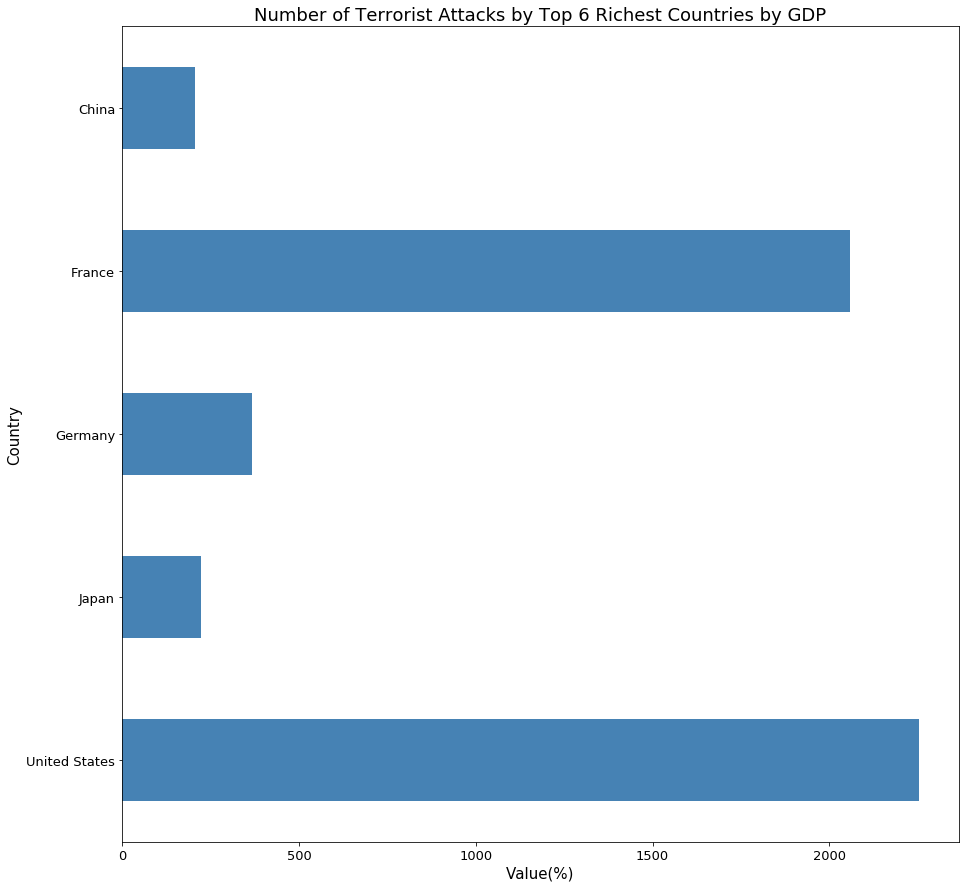

In [331]:
ax = dft6["nattacks"].plot(kind='barh',color = 'steelblue')
plt.gca().invert_yaxis()
ax.set_xlabel('Value(%)', fontsize=15)
ax.set_ylabel('Country', fontsize=15)
ax.set_title("Number of Terrorist Attacks by Top 6 Richest Countries by GDP",fontsize=18)

In [321]:
df_b6_gdp = df_gtd_points[(df_gtd_points["country_txt"] == "Cambodia")|
                          (df_gtd_points["country_txt"] == "Uganda") |
                           (df_gtd_points["country_txt"] == "Eritrea") |
                           (df_gtd_points["country_txt"] == "Burundi") |
                           (df_gtd_points["country_txt"] == "Mozambique") |
                           (df_gtd_points["country_txt"] == "South Sudan")]
len(df_b6_gdp)

1340

In [324]:
df_b6 = df_b6_gdp[["nattacks","nkill","country_txt","nwound","attacktype1_txt"]]

In [329]:
df_b6 = df_b6_gdp[["nattacks","nkill","country_txt","nwound","attacktype1_txt"]]
dfb6 = df_b6.groupby("country_txt").sum()

Text(0.5, 1.0, 'Number of Terrorist Attacks by Top 6 Poorest Countries by GDP/PC')

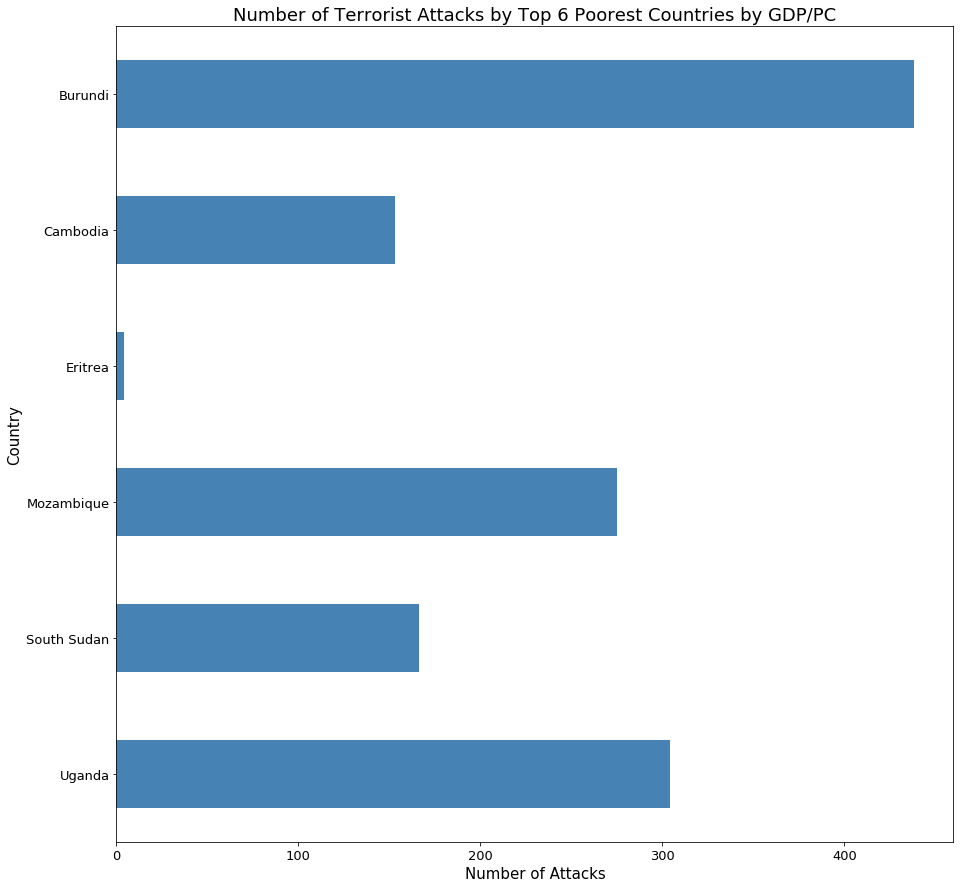

In [330]:
ax = dfb6["nattacks"].plot(kind='barh',color = 'steelblue')
plt.gca().invert_yaxis()
ax.set_xlabel('Number of Attacks', fontsize=15)
ax.set_ylabel('Country', fontsize=15)
ax.set_title("Number of Terrorist Attacks by Top 6 Poorest Countries by GDP/PC",fontsize=18)